# Enrichment Analysis Notebook

Compares the results of SPINDOCTOR gene set summarization vs statistical ontological enrichment.

Draft: https://docs.google.com/document/d/1H103ux6Dd1_bPM0un4RwutBLcYJx-0ybil2AwlAvG_Q/edit#

## Initial setup

Here we take care of imports, defining the data dictionary for the pandas dataframes

In [98]:
!pip --version

pip 23.2.1 from /Users/marcin/Library/Caches/pypoetry/virtualenvs/enrichgpt-results-TVy_rkkG-py3.10/lib/python3.10/site-packages/pip (python 3.10)


In [99]:
!pip install statsmodels


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [100]:
!pip list

Package                    Version
-------------------------- -----------
adeft                      0.11.2
aiohttp                    3.8.4
aiosignal                  1.3.1
airium                     0.2.5
altair                     4.2.2
aniso8601                  9.0.1
antlr4-python3-runtime     4.9.3
anyio                      3.7.0
appdirs                    1.4.4
appnope                    0.1.3
argon2-cffi                21.3.0
argon2-cffi-bindings       21.2.0
arrow                      1.2.3
asttokens                  2.2.1
async-timeout              4.0.2
attrs                      23.1.0
backcall                   0.2.0
bcp47                      0.0.4
beautifulsoup4             4.12.2
bioc                       2.0.post5
bioregistry                0.9.31
bleach                     6.0.0
blinker                    1.6.2
boto3                      1.7.84
botocore                   1.10.84
cachetools                 5.3.1
cachier                    2.1.1
cattrs                


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [101]:
#!pip install --force-reinstall --upgrade more-itertools


In [102]:
import yaml
from yaml import Loader
from collections import defaultdict
import pandas as pd
import numpy as np
from scipy.stats import kstest, ttest_ind, wilcoxon
import math
from statsmodels.stats.multitest import multipletests

#import itertools as it
#import collections as ct
#import more_itertools as mit

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import colorsys
import seaborn as sns

from oaklib import get_adapter
from oaklib.datamodels.vocabulary import IS_A, PART_OF
from ontogpt.evaluation.enrichment.eval_enrichment import EvalEnrichment
go = get_adapter("sqlite:obo:go")
hgnc = get_adapter("sqlite:obo:hgnc")

In [103]:
TURBO = "gpt-3.5-turbo"
DAVINCI = "text-davinci-003"
GPT4 = "gpt-4"
MODELS = [TURBO, DAVINCI, GPT4]

In [104]:
# data dictionary
MODEL = "model"
METHOD = "method"
HAS_TOP_HIT = "has top term"
IN_TOP_5 = "in top 5"
IN_TOP_10 = "in top 10"
RANK = "rank"
SIZE_OVERLAP = "size overlap"
SIMILARITY = "similarity"
NR_SIZE_OVERLAP = "nr size overlap"
NR_SIMILARITY = "nr similarity"
GENESET = "gene_set"
PROMPT_VARIANT = "prompt_variant"
SOURCE_GENESET = "source geneset"
GENESET_DESCRIPTION = "description"
GENESET_SIZE = "gene_set_size"
TRUNCATION_FACTOR = "truncation factor"
NUM_TERMS = "num terms"
NUM_GO_TERMS = "num GO terms"
UNPARSED = "unparsed"
NUM_UNPARSED = "num unparsed"
TERM_IDS = "term ids"
GO_TERM_IDS = "go term ids"
GO_TERM_P_VALUES = "go term p values"
MAX_P_VALUE = "max p value"
MIN_P_VALUE = "min p value"
MEAN_P_VALUE = "mean p value"
PROPORTION_SIGNIFICANT = "proportion significant"
NOVEL = "unannotated"
NOVEL_LABELS = "unannotated labels"
NUM_NOVEL = "num unannotated"
GENE_RANDOMIZATION_FACTOR = "gene_randomization_factor"
SUMMARY = "summary"
TP_num = "number of true positives across a set of gene GO annotations"
FP_num = "number of false positives across a set of gene GO annotations"
TP = "true positive rate across a set of gene GO annotations"
FP = "false positive rate across a set of gene GO annotations"
PRECISION = "precision"
RECALL = "recall"
RECALL_GENERAL = "recall_general"
RECALL_SPECIFIC = "recall_specific"
CUTOFF = "cutoff"

In [105]:
from ontogpt.evaluation.enrichment.eval_enrichment import GeneSetComparison

In [106]:
df = pd.read_csv('results/processed.tsv', sep='\t', header=0, index_col=0)
df

,cutoff,closure,top_n,source,model,method,method_desc,run,truncation_factor,prompt_variant,...,unparsed,true_positive_terms,false_positive_terms,unparsed_terms,gene_set_size,precision,recall,recall_general,recall_specific,f1_score
name,,,,,,,,,,,,,,,,,,,,,
glycolysis-gocam-0-0.005,0.005,False,5,NONE,4.0,gpt,no_synopsis-4,gpt-4.no_synopsis.v1,1.0,v1,...,2,GO:0006096,GO:0006006,energy production|atp generation,10,0.500000,0.500000,1.000000,0.200000,0.285714
glycolysis-gocam-0-0.005,0.005,False,10,NONE,4.0,gpt,no_synopsis-4,gpt-4.no_synopsis.v1,1.0,v1,...,2,GO:0006096,GO:0006006,energy production|atp generation,10,0.500000,0.500000,0.200000,0.200000,0.166667
glycolysis-gocam-0-0.005,0.005,False,25,NONE,4.0,gpt,no_synopsis-4,gpt-4.no_synopsis.v1,1.0,v1,...,2,GO:0006096|GO:0006006,NaN,energy production|atp generation,10,1.000000,1.000000,0.250000,0.153846,0.148148
glycolysis-gocam-0-0.005,0.005,False,5000,NONE,4.0,gpt,no_synopsis-4,gpt-4.no_synopsis.v1,1.0,v1,...,2,GO:0006096|GO:0006006,NaN,energy production|atp generation,10,1.000000,1.000000,0.250000,0.142857,0.097561
glycolysis-gocam-0-0.005,0.005,True,5,NONE,4.0,gpt,no_synopsis-4,gpt-4.no_synopsis.v1,1.0,v1,...,2,GO:0006096|GO:0019318|GO:0061621|GO:0006094,NaN,energy production|atp generation,10,1.000000,1.000000,0.666667,0.800000,0.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HALLMARK_MTORC1_SIGNALING-1-99,99.000,False,5000,NaN,NaN,NaN,NaN,closure,NaN,NaN,...,0,GO:0044283|GO:0044281|GO:0005737|GO:0019752|GO...,NaN,NaN,180,1.000000,1.000000,1.000000,1.000000,1.000000
HALLMARK_MTORC1_SIGNALING-1-99,99.000,True,5,NaN,NaN,NaN,NaN,closure,NaN,NaN,...,0,GO:0044283|GO:0005737|GO:0019752|GO:0036094|GO...,GO:0008525|GO:0009749|GO:0019899|GO:0050709|GO...,NaN,180,0.000794,0.000794,1.000000,1.000000,0.001587
HALLMARK_MTORC1_SIGNALING-1-99,99.000,True,10,NaN,NaN,NaN,NaN,closure,NaN,NaN,...,0,GO:0044283|GO:0005737|GO:0019752|GO:0036094|GO...,GO:0008525|GO:0009749|GO:0019899|GO:0050709|GO...,NaN,180,0.001720,0.001720,1.000000,1.000000,0.003434


In [107]:
grouped_data = df.groupby(['source', 'model', 'method'])[['true_positives', 'false_positives', 'false_negatives']].sum().reset_index()

# Calculate precision, recall, and F1-score for each group
grouped_data['precision'] = grouped_data['true_positives'] / (grouped_data['true_positives'] + grouped_data['false_positives'])
grouped_data['recall'] = grouped_data['true_positives'] / (grouped_data['true_positives'] + grouped_data['false_negatives'])
grouped_data['f1_score'] = 2 * ((grouped_data['precision'] * grouped_data['recall']) / (grouped_data['precision'] + grouped_data['recall']))
grouped_data

,source,model,method,true_positives,false_positives,false_negatives,precision,recall,f1_score
0,GO,3.0,gpt,34198,36751,1502346,0.482008,0.022256,0.042548
1,GO,3.5,gpt,34128,14844,1502416,0.696888,0.022211,0.043050
2,GO,4.0,gpt,61838,24122,1474706,0.719381,0.040245,0.076225
3,NONE,3.0,gpt,35898,16532,1500646,0.684684,0.023363,0.045184
4,NONE,3.5,gpt,48870,18781,1487674,0.722384,0.031805,0.060928
5,NONE,4.0,gpt,51356,19080,1485188,0.729116,0.033423,0.063916
6,RefSeq,3.0,gpt,40307,22012,1496237,0.646785,0.026232,0.050420
7,RefSeq,3.5,gpt,43319,15097,1493225,0.741561,0.028192,0.054320
8,RefSeq,4.0,gpt,44079,18650,1492465,0.702689,0.028687,0.055124


In [108]:
grouped_data_cutoff_combination = df.groupby(['cutoff', 'source', 'model', 'method'])[['true_positives', 'false_positives', 'false_negatives']].sum().reset_index()

# Calculate precision, recall, and F1-score for each group
grouped_data_cutoff_combination['precision'] = grouped_data_cutoff_combination['true_positives'] / (grouped_data_cutoff_combination['true_positives'] + grouped_data_cutoff_combination['false_positives'])
grouped_data_cutoff_combination['recall'] = grouped_data_cutoff_combination['true_positives'] / (grouped_data_cutoff_combination['true_positives'] + grouped_data_cutoff_combination['false_negatives'])
grouped_data_cutoff_combination['f1_score'] = 2 * ((grouped_data_cutoff_combination['precision'] * grouped_data_cutoff_combination['recall']) / (grouped_data_cutoff_combination['precision'] + grouped_data_cutoff_combination['recall']))
grouped_data_cutoff_combination

,cutoff,source,model,method,true_positives,false_positives,false_negatives,precision,recall,f1_score
0,0.005,GO,3.0,gpt,5156,13022,95620,0.283640,0.051163,0.086689
1,0.005,GO,3.5,gpt,6635,5122,94141,0.564345,0.065839,0.117921
2,0.005,GO,4.0,gpt,10300,8481,90476,0.548427,0.102207,0.172303
3,0.005,NONE,3.0,gpt,4891,5747,95885,0.459767,0.048533,0.087799
4,0.005,NONE,3.5,gpt,9943,6501,90833,0.604658,0.098664,0.169647
5,0.005,NONE,4.0,gpt,9237,6648,91539,0.581492,0.091659,0.158356
6,0.005,RefSeq,3.0,gpt,5268,7690,95508,0.406544,0.052274,0.092637
7,0.005,RefSeq,3.5,gpt,8506,5211,92270,0.620106,0.084405,0.148586
8,0.005,RefSeq,4.0,gpt,7839,6509,92937,0.546348,0.077786,0.136184
9,0.050,GO,3.0,gpt,6067,13229,119291,0.314417,0.048397,0.083883


/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_13783/84159181.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_combination['label'] = data_combination['source'] + '-' + data_combination['model'].astype(str) + '-' + data_combination['method']
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_13783/84159181.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_combination['label'] = data_combination['source'] + '-' + data_combination['model'].astype(str) + '-' + data_combinat

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_13783/84159181.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_combination['label'] = data_combination['source'] + '-' + data_combination['model'].astype(str) + '-' + data_combination['method']
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_13783/84159181.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_combination['label'] = data_combination['source'] + '-' + data_combination['model'].astype(str) + '-' + data_combinat

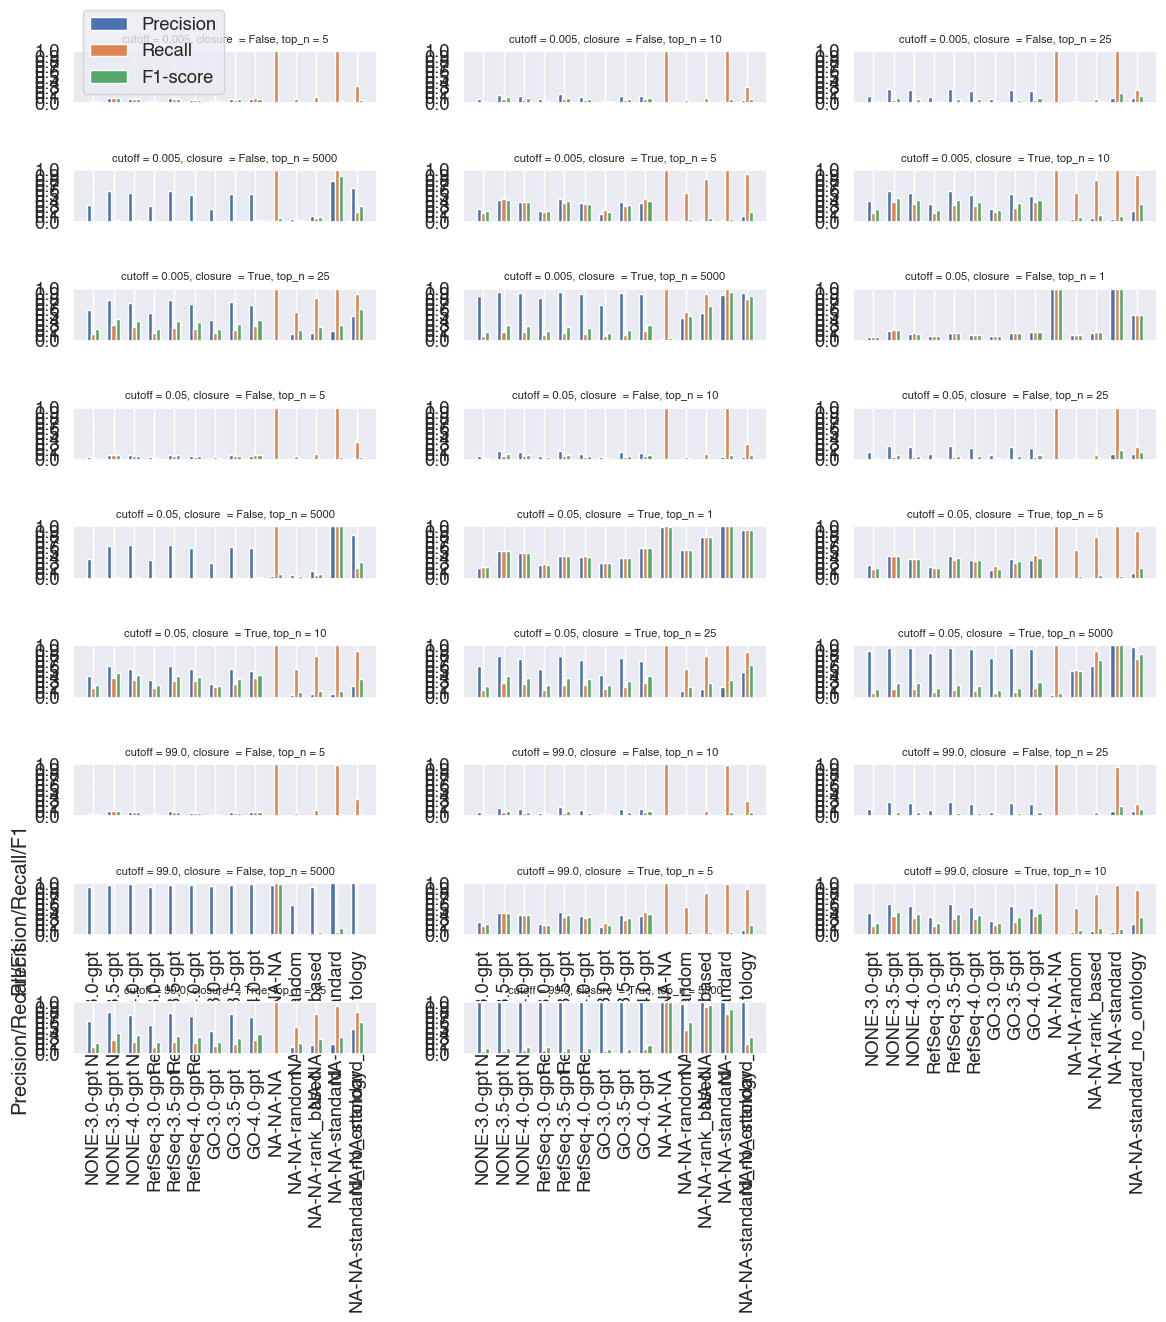

In [109]:
cutoff_values = [0, 0.05, 0.005, 99]
data_filled = df.fillna("NA")

grouped_data_filled = data_filled.groupby(['cutoff', 'closure', 'top_n', 'source', 'model', 'method'])[['true_positives', 'false_positives', 'false_negatives']].sum().reset_index()
grouped_data_filled['precision'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_positives'])
grouped_data_filled['recall'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_negatives'])
grouped_data_filled['f1_score'] = 2 * ((grouped_data_filled['precision'] * grouped_data_filled['recall']) / (grouped_data_filled['precision'] + grouped_data_filled['recall']))

order_prefix = ["NONE", "RefSeq", "GO", "NA"]

unique_combinations = grouped_data_filled[['cutoff', 'closure', 'top_n']].drop_duplicates().values

fig, ax = plt.subplots(9, 3, figsize=(12, 11))
plt.tight_layout(pad=1.5)

for idx, (cutoff, closure, top_n) in enumerate(unique_combinations):
    row = idx // 3
    column = idx % 3
    
    data_combination = grouped_data_filled[(grouped_data_filled['cutoff'] == cutoff) & (grouped_data_filled['closure'] == closure) & (grouped_data_filled['top_n'] == top_n)]
    data_combination['label'] = data_combination['source'] + '-' + data_combination['model'].astype(str) + '-' + data_combination['method']
    
    # Reordering based on the specified order
    data_combination = data_combination.sort_values(by='label', key=lambda x: [order_prefix.index(i.split('-')[0]) for i in x])
    
    x_newest = np.arange(len(data_combination['label']))
    width_newest = 0.2
    
    ax[row, column].bar(x_newest - width_newest, data_combination['precision'], width_newest, label='Precision')
    ax[row, column].bar(x_newest, data_combination['recall'], width_newest, label='Recall')
    ax[row, column].bar(x_newest + width_newest, data_combination['f1_score'], width_newest, label='F1-score')

    ax[row, column].set_title(f'cutoff = {cutoff}, closure  = {closure}, top_n = {top_n}', fontsize=8)
    ax[row, column].set_ylim(0, 1)
    ax[row, column].set_yticks(np.arange(0, 1.1, 0.1))
    ax[row, column].grid(axis='y', which='major', linestyle='--', linewidth=0.5, alpha=0.2)
    
    if column == 0 and (row == 7 or row == 8):
        ax[row, column].set_ylabel('Precision/Recall/F1')
    if row == 7 or row == 8:
        ax[row, column].set_xticks(x_newest)
        ax[row, column].set_xticklabels(data_combination['label'], rotation=90)
    else:
        ax[row, column].set_xticks(x_newest)
        ax[row, column].set_xticklabels([])
        
    if idx == 0:
        ax[row, column].legend()

# Hide the bottom right plot
ax[8, 2].axis('off')

plt.savefig("process_precision_recall_allGPT.pdf", format="pdf", bbox_inches="tight")
plt.show()


def custom_order(label):
    prefix_order = ["NONE", "RefSeq", "GO", "NA"]
    model_order = ["3.0-GPT", "3.5-GPT", "4.0-GPT"]
    
    for p in prefix_order:
        if label.startswith(p):
            return prefix_order.index(p), model_order.index(label.split('-')[1])
    return len(prefix_order)


/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_13783/2630182969.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_combination['label'] = data_combination['source'] + '-' + data_combination['model'].astype(str) + '-' + data_combination['method']
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_13783/2630182969.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_combination['label_order'] = data_combination['label'].apply(label_order)
/var/folders/hx/svkm0dlj0bd9689lm21_7fy

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_13783/2630182969.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_combination['label'] = data_combination['source'] + '-' + data_combination['model'].astype(str) + '-' + data_combination['method']
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_13783/2630182969.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_combination['label_order'] = data_combination['label'].apply(label_order)
/var/folders/hx/svkm0dlj0bd9689lm21_7fy

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_13783/2630182969.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_combination['label'] = data_combination['source'] + '-' + data_combination['model'].astype(str) + '-' + data_combination['method']
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_13783/2630182969.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_combination['label_order'] = data_combination['label'].apply(label_order)
/var/folders/hx/svkm0dlj0bd9689lm21_7fy

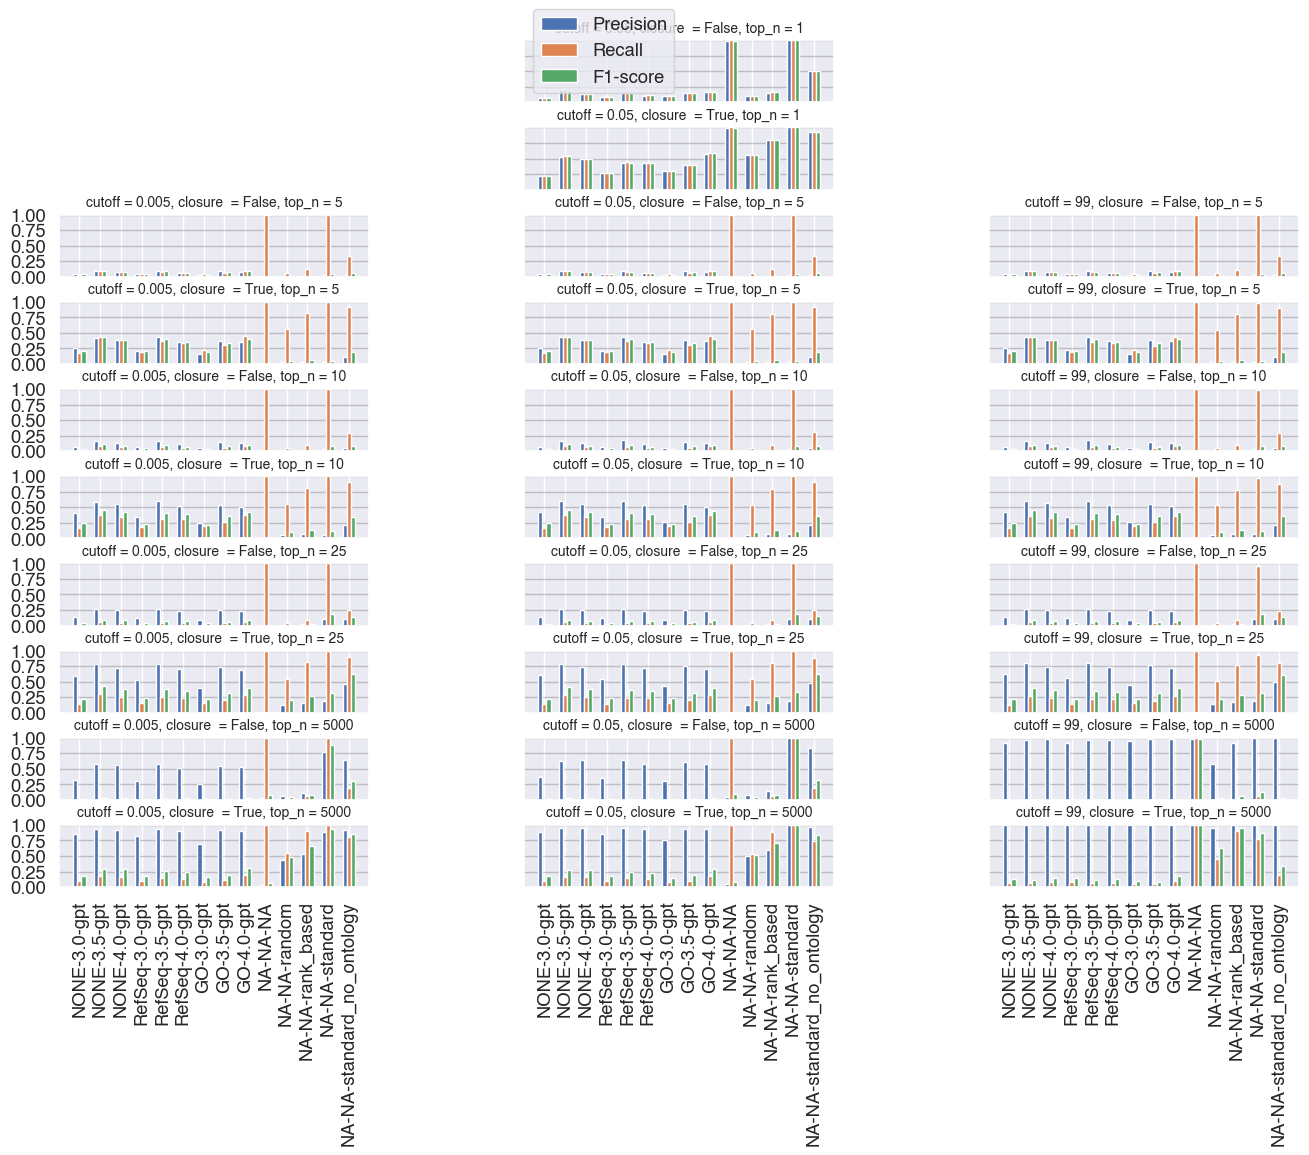

In [110]:
def custom_order(label):
    prefix_order = ["NONE", "RefSeq", "GO", "NA"]
    suffix_order = ["3.0-GPT", "3.5GPT", "4.0-GPT"]
    
    try:
        prefix_parts = label.split('-')
        prefix_weight = prefix_order.index(prefix_parts[0])
        
        suffix = '-'.join(prefix_parts[1:])
        suffix_weight = suffix_order.index(suffix)
    except ValueError:
        return (999, 999)  # put unexpected values at the end
    
    return prefix_weight, suffix_weight

def label_order(label):
    prefixes = ["NONE", "RefSeq", "GO", "NA"]
    for i, prefix in enumerate(prefixes):
        if label.startswith(prefix):
            return i
    return len(prefixes)  # Return a value that puts any other labels at the end


cutoff_values = sorted([0.05, 0.005, 99])

data_filled = df.fillna("NA")

grouped_data_filled = data_filled.groupby(['cutoff', 'closure', 'top_n', 'source', 'model', 'method'])[['true_positives', 'false_positives', 'false_negatives']].sum().reset_index()

grouped_data_filled['precision'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_positives'])
grouped_data_filled['recall'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_negatives'])
grouped_data_filled['f1_score'] = 2 * ((grouped_data_filled['precision'] * grouped_data_filled['recall']) / (grouped_data_filled['precision'] + grouped_data_filled['recall']))

grouped_data_filled['sort_order'] = grouped_data_filled['source'].apply(custom_order)
grouped_data_filled = grouped_data_filled.sort_values(['sort_order', 'top_n', 'closure'])

unique_combinations_closure_topn = sorted(grouped_data_filled[['closure', 'top_n']].drop_duplicates().values, key=lambda x: (x[1], x[0]))

num_rows = len(unique_combinations_closure_topn)
num_cols = len(cutoff_values)

fig, ax = plt.subplots(num_rows, num_cols, figsize=(16, 11), gridspec_kw={"hspace": 0.4, "wspace": 0.5})
        
for row_idx, (closure, top_n) in enumerate(unique_combinations_closure_topn):
    for col_idx, cutoff in enumerate(cutoff_values):
        
        if (col_idx < 1 or col_idx >= num_cols - 1) and (row_idx == 0 or row_idx == 1):
            ax[row_idx, col_idx].axis('off') 
            continue
            
        data_combination = grouped_data_filled[(grouped_data_filled['cutoff'] == cutoff) & (grouped_data_filled['closure'] == closure) & (grouped_data_filled['top_n'] == top_n)]
        data_combination['label'] = data_combination['source'] + '-' + data_combination['model'].astype(str) + '-' + data_combination['method']

        # Sort data_combination based on the label_order
        data_combination['label_order'] = data_combination['label'].apply(label_order)
        data_combination = data_combination.sort_values('label_order')
        
        x_newest = np.arange(len(data_combination['label']))
        width_newest = 0.2

        ax[row_idx, col_idx].bar(x_newest - width_newest, data_combination['precision'], width_newest, label='Precision')
        ax[row_idx, col_idx].bar(x_newest, data_combination['recall'], width_newest, label='Recall')
        ax[row_idx, col_idx].bar(x_newest + width_newest, data_combination['f1_score'], width_newest, label='F1-score')
        
        ax[row_idx, col_idx].set_title(f'cutoff = {cutoff}, closure  = {closure}, top_n = {top_n}', fontsize=10)
        
        ax[row_idx, col_idx].set_ylim(0, 1)
        
        # Change y-axis tick marks
        ax[row_idx, col_idx].set_yticks(np.arange(0, 1.1, 0.25))
        if col_idx != 0:  # Hide y-axis labels for non-left columns
            ax[row_idx, col_idx].set_yticklabels([])
        
        # Set x-axis ticks
        ax[row_idx, col_idx].set_xticks(x_newest)
        if row_idx == num_rows - 1:  # Adjusting the condition for x-tick labels for the last row
            ax[row_idx, col_idx].set_xticklabels(data_combination['label'], rotation=90)
        else:
            ax[row_idx, col_idx].set_xticklabels([])
    
        # Add horizontal gridlines
        ax[row_idx, col_idx].grid(axis='y', which='major', color='black', alpha=0.2)
    
        if row_idx == 0 and col_idx == num_cols - 2:
            ax[row_idx, col_idx].legend()

plt.tight_layout()
plt.savefig("process_precision_recall_allGPT.pdf", format="pdf", bbox_inches="tight")
plt.show()


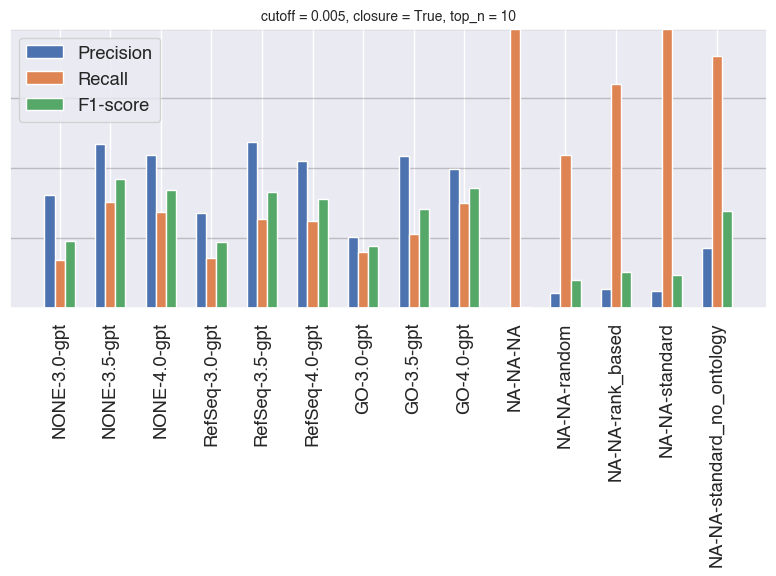

In [111]:
def custom_order(label):
    prefix_order = ["NONE", "RefSeq", "GO", "NA"]
    suffix_order = ["3.0-GPT", "3.5GPT", "4.0-GPT"]
    
    try:
        prefix_parts = label.split('-')
        prefix_weight = prefix_order.index(prefix_parts[0])
        
        suffix = '-'.join(prefix_parts[1:])
        suffix_weight = suffix_order.index(suffix)
    except ValueError:
        return (999, 999)  # put unexpected values at the end
    
    return prefix_weight, suffix_weight

def label_order(label):
    prefixes = ["NONE", "RefSeq", "GO", "NA"]
    for i, prefix in enumerate(prefixes):
        if label.startswith(prefix):
            return i
    return len(prefixes)  # Return a value that puts any other labels at the end


data_filled = df.fillna("NA")
condition = (
    (data_filled['cutoff'] == 0.005) &
    (data_filled['closure'] == True) &
    (data_filled['top_n'] == 10)
)
filtered_data = data_filled[condition]
filtered_data.reset_index(drop=True, inplace=True)

grouped_data_filled = filtered_data.groupby(['cutoff', 'closure', 'top_n', 'source', 'model', 'method'])[['true_positives', 'false_positives', 'false_negatives']].sum().reset_index()

grouped_data_filled['precision'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_positives'])
grouped_data_filled['recall'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_negatives'])
grouped_data_filled['f1_score'] = 2 * ((grouped_data_filled['precision'] * grouped_data_filled['recall']) / (grouped_data_filled['precision'] + grouped_data_filled['recall']))

grouped_data_filled['sort_order'] = grouped_data_filled['source'].apply(custom_order)
grouped_data_filled = grouped_data_filled.sort_values(['sort_order', 'top_n', 'closure'])


fig, ax = plt.subplots(1, 1, figsize=(8, 6))  # Create a single subplot

data_combination = grouped_data_filled#filtered_data[(filtered_data['cutoff'] == 0.005) & (filtered_data['closure'] == True) & (filtered_data['top_n'] == 10)]
data_combination['label'] = data_combination['source'] + '-' + data_combination['model'].astype(str) + '-' + data_combination['method']

# Sort data_combination based on the label_order
data_combination['label_order'] = data_combination['label'].apply(label_order)
data_combination = data_combination.sort_values('label_order')

x_newest = np.arange(len(data_combination['label']))
width_newest = 0.2

ax.bar(x_newest - width_newest, data_combination['precision'], width_newest, label='Precision')
ax.bar(x_newest, data_combination['recall'], width_newest, label='Recall')
ax.bar(x_newest + width_newest, data_combination['f1_score'], width_newest, label='F1-score')

ax.set_title(f'cutoff = 0.005, closure = True, top_n = 10', fontsize=10)

ax.set_ylim(0, 1)

# Change y-axis tick marks
ax.set_yticks(np.arange(0, 1.1, 0.25))
ax.set_yticklabels([])  # Hide y-axis labels

# Set x-axis ticks
ax.set_xticks(x_newest)
ax.set_xticklabels(data_combination['label'], rotation=90)

# Add horizontal gridlines
ax.grid(axis='y', which='major', color='black', alpha=0.2)
ax.legend()

plt.tight_layout()
plt.savefig("process_precision_recall_specific_0.005_true_10.pdf", format="pdf", bbox_inches="tight")
plt.show()

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_13783/2437827099.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_combination['label'] = filtered_data_combination['source'] + '-' + filtered_data_combination['model'].astype(str) + '-' + filtered_data_combination['method']
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_13783/2437827099.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_combination['label_order'] = filtered_data_combination['label'].appl

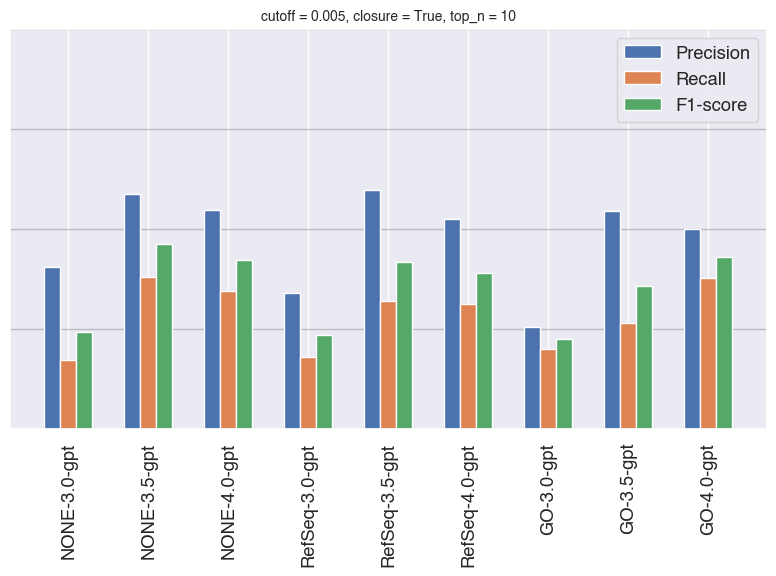

In [112]:
def custom_order(label):
    prefix_order = ["NONE", "RefSeq", "GO", "NA"]
    suffix_order = ["3.0-GPT", "3.5GPT", "4.0-GPT"]
    
    try:
        prefix_parts = label.split('-')
        prefix_weight = prefix_order.index(prefix_parts[0])
        
        suffix = '-'.join(prefix_parts[1:])
        suffix_weight = suffix_order.index(suffix)
    except ValueError:
        return (999, 999)  # put unexpected values at the end
    
    return prefix_weight, suffix_weight

def label_order(label):
    prefixes = ["NONE", "RefSeq", "GO", "NA"]
    for i, prefix in enumerate(prefixes):
        if label.startswith(prefix):
            return i
    return len(prefixes)  # Return a value that puts any other labels at the end

data_filled = df.fillna("NA")
condition = (
    (data_filled['cutoff'] == 0.005) &
    (data_filled['closure'] == True) &
    (data_filled['top_n'] == 10)
)
filtered_data = data_filled[condition]
filtered_data.reset_index(drop=True, inplace=True)

grouped_data_filled = filtered_data.groupby(['cutoff', 'closure', 'top_n', 'source', 'model', 'method'])[['true_positives', 'false_positives', 'false_negatives']].sum().reset_index()

grouped_data_filled['precision'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_positives'])
grouped_data_filled['recall'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_negatives'])
grouped_data_filled['f1_score'] = 2 * ((grouped_data_filled['precision'] * grouped_data_filled['recall']) / (grouped_data_filled['precision'] + grouped_data_filled['recall']))

grouped_data_filled['sort_order'] = grouped_data_filled['source'].apply(custom_order)
grouped_data_filled = grouped_data_filled.sort_values(['sort_order', 'top_n', 'closure'])

# Filter out sets with 'NA-NA' label prefix
filtered_data_combination = grouped_data_filled[~grouped_data_filled['source'].str.startswith('NA')]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))  # Create a single subplot

filtered_data_combination['label'] = filtered_data_combination['source'] + '-' + filtered_data_combination['model'].astype(str) + '-' + filtered_data_combination['method']

# Sort data_combination based on the label_order
filtered_data_combination['label_order'] = filtered_data_combination['label'].apply(label_order)
filtered_data_combination = filtered_data_combination.sort_values('label_order')

x_newest = np.arange(len(filtered_data_combination['label']))
width_newest = 0.2

ax.bar(x_newest - width_newest, filtered_data_combination['precision'], width_newest, label='Precision')
ax.bar(x_newest, filtered_data_combination['recall'], width_newest, label='Recall')
ax.bar(x_newest + width_newest, filtered_data_combination['f1_score'], width_newest, label='F1-score')

ax.set_title(f'cutoff = 0.005, closure = True, top_n = 10', fontsize=10)

ax.set_ylim(0, 1)

# Change y-axis tick marks
ax.set_yticks(np.arange(0, 1.1, 0.25))
ax.set_yticklabels([])  # Hide y-axis labels

# Set x-axis ticks
ax.set_xticks(x_newest)
ax.set_xticklabels(filtered_data_combination['label'], rotation=90)

# Add horizontal gridlines
ax.grid(axis='y', which='major', color='black', alpha=0.2)
ax.legend()

plt.tight_layout()
plt.savefig("process_precision_recall_specific_0.005_true_10.pdf", format="pdf", bbox_inches="tight")
plt.show()

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_13783/1927908741.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_combination['label'] = filtered_data_combination['source'] + '-' + filtered_data_combination['model'].astype(str) + '-' + filtered_data_combination['method']


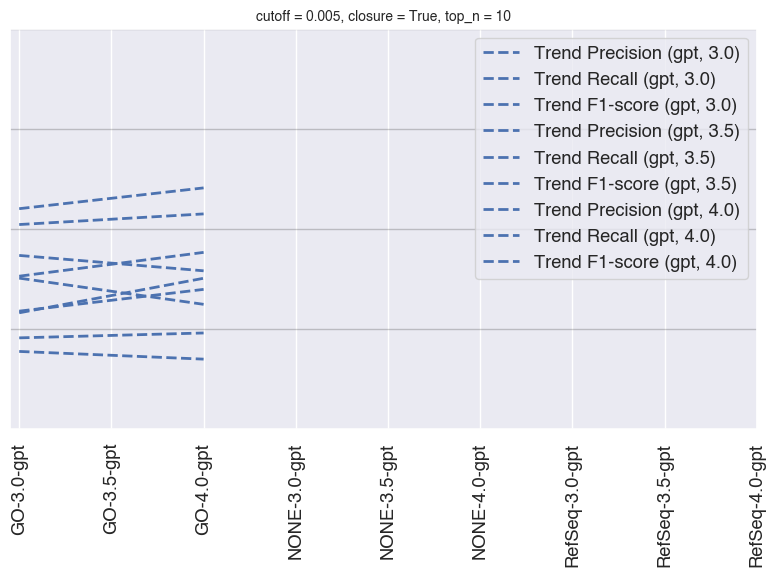

In [113]:
def custom_order(label):
    prefix_order = ["NONE", "RefSeq", "GO", "NA"]
    suffix_order = ["3.0-GPT", "3.5GPT", "4.0-GPT"]
    
    try:
        prefix_parts = label.split('-')
        prefix_weight = prefix_order.index(prefix_parts[0])
        
        suffix = '-'.join(prefix_parts[1:])
        suffix_weight = suffix_order.index(suffix)
    except ValueError:
        return (999, 999)  # put unexpected values at the end
    
    return prefix_weight, suffix_weight

def label_order(label):
    prefixes = ["NONE", "RefSeq", "GO", "NA"]
    for i, prefix in enumerate(prefixes):
        if label.startswith(prefix):
            return i
    return len(prefixes)  # Return a value that puts any other labels at the end

data_filled = df.fillna("NA")
condition = (
    (data_filled['cutoff'] == 0.005) &
    (data_filled['closure'] == True) &
    (data_filled['top_n'] == 10)
)
filtered_data = data_filled[condition]
filtered_data.reset_index(drop=True, inplace=True)

grouped_data_filled = filtered_data.groupby(['cutoff', 'closure', 'top_n', 'source', 'model', 'method'])[['true_positives', 'false_positives', 'false_negatives']].sum().reset_index()

grouped_data_filled['precision'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_positives'])
grouped_data_filled['recall'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_negatives'])
grouped_data_filled['f1_score'] = 2 * ((grouped_data_filled['precision'] * grouped_data_filled['recall']) / (grouped_data_filled['precision'] + grouped_data_filled['recall']))

grouped_data_filled['sort_order'] = grouped_data_filled['source'].apply(custom_order)
grouped_data_filled = grouped_data_filled.sort_values(['sort_order', 'top_n', 'closure'])

# Filter out sets with 'NA-NA' label prefix
filtered_data_combination = grouped_data_filled[~grouped_data_filled['source'].str.startswith('NA')]
filtered_data_combination['label'] = filtered_data_combination['source'] + '-' + filtered_data_combination['model'].astype(str) + '-' + filtered_data_combination['method']
filtered_data_combination.reset_index(inplace=True)

grouped_by_method = filtered_data_combination.groupby('method')[['precision', 'recall', 'f1_score']].mean()
#grouped_by_method.reset_index(inplace=True)

# Get the unique 'method' values in the order of appearance
unique_methods = filtered_data_combination['method'].unique()
unique_models = filtered_data_combination['model'].unique()

# Set the colors for the bars
colors = ['b', 'g', 'r']

fig, ax = plt.subplots(1, 1, figsize=(8, 6))  # Create a single subplot

x_newest = np.arange(len(filtered_data_combination['label']))
width_newest = 0.2

# Add trend lines for each metric and each combination of 'method' and 'model'
for idx, method in enumerate(unique_methods):
    for model in unique_models:
        subset = filtered_data_combination[(filtered_data_combination['method'] == method) & (filtered_data_combination['model'] == model)]
        
        if len(subset) > 0:
            precision_trend = np.polyfit(x_newest[:len(subset)], subset['precision'], 1)
            recall_trend = np.polyfit(x_newest[:len(subset)], subset['recall'], 1)
            f1_score_trend = np.polyfit(x_newest[:len(subset)], subset['f1_score'], 1)

            ax.plot(x_newest[:len(subset)], np.polyval(precision_trend, x_newest[:len(subset)]), '--', color=colors[idx], label=f'Trend Precision ({method}, {model})', linewidth=2)
            ax.plot(x_newest[:len(subset)], np.polyval(recall_trend, x_newest[:len(subset)]), '--', color=colors[idx], label=f'Trend Recall ({method}, {model})', linewidth=2)
            ax.plot(x_newest[:len(subset)], np.polyval(f1_score_trend, x_newest[:len(subset)]), '--', color=colors[idx], label=f'Trend F1-score ({method}, {model})', linewidth=2)

ax.set_title(f'cutoff = 0.005, closure = True, top_n = 10', fontsize=10)

ax.set_ylim(0, 1)

# Change y-axis tick marks
ax.set_yticks(np.arange(0, 1.1, 0.25))
ax.set_yticklabels([])  # Hide y-axis labels

# Set x-axis ticks
ax.set_xticks(x_newest)
ax.set_xticklabels(filtered_data_combination['label'], rotation=90)

# Add horizontal gridlines
ax.grid(axis='y', which='major', color='black', alpha=0.2)
ax.legend()

plt.tight_layout()
plt.savefig("process_precision_recall_specific_0.005_true_10_with_trends.pdf", format="pdf", bbox_inches="tight")
plt.show()

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_13783/3705466844.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_combination['label'] = filtered_data_combination['source'] + '-' + filtered_data_combination['model'].astype(str) + '-' + filtered_data_combination['method']
/Users/marcin/Library/Caches/pypoetry/virtualenvs/enrichgpt-results-TVy_rkkG-py3.10/lib/python3.10/site-packages/seaborn/regression.py:582: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


KeyError: "['label_order'] not in index"

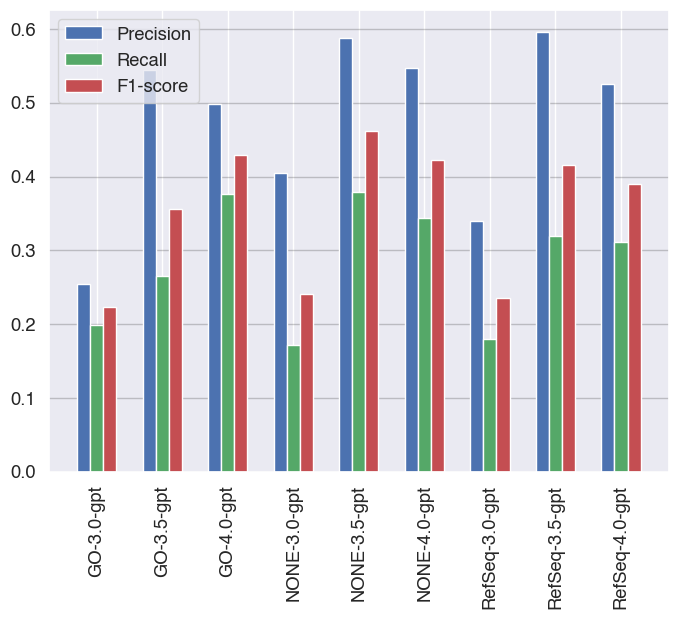

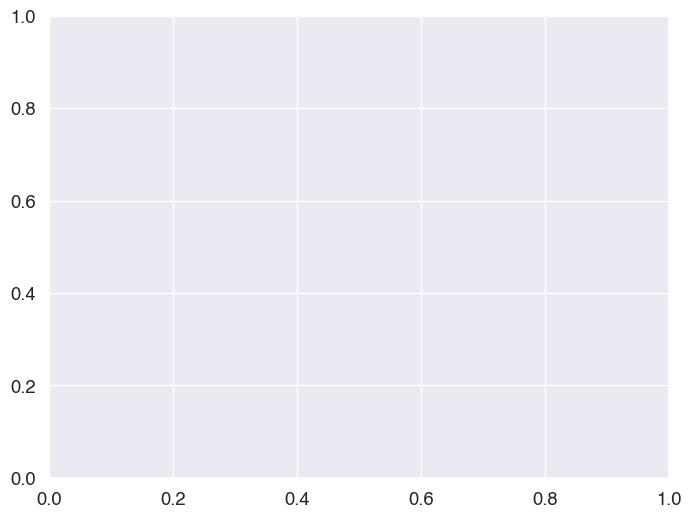

In [114]:
import seaborn as sns

def custom_order(label):
    prefix_order = ["NONE", "RefSeq", "GO", "NA"]
    suffix_order = ["3.0-GPT", "3.5GPT", "4.0-GPT"]
    
    try:
        prefix_parts = label.split('-')
        prefix_weight = prefix_order.index(prefix_parts[0])
        
        suffix = '-'.join(prefix_parts[1:])
        suffix_weight = suffix_order.index(suffix)
    except ValueError:
        return (999, 999)  # put unexpected values at the end
    
    return prefix_weight, suffix_weight

def label_order(label):
    prefixes = ["NONE", "RefSeq", "GO", "NA"]
    for i, prefix in enumerate(prefixes):
        if label.startswith(prefix):
            return i
    return len(prefixes)  # Return a value that puts any other labels at the end

data_filled = df.fillna("NA")
condition = (
    (data_filled['cutoff'] == 0.005) &
    (data_filled['closure'] == True) &
    (data_filled['top_n'] == 10)
)
filtered_data = data_filled[condition]
filtered_data.reset_index(drop=True, inplace=True)

grouped_data_filled = filtered_data.groupby(['cutoff', 'closure', 'top_n', 'source', 'model', 'method'])[['true_positives', 'false_positives', 'false_negatives']].sum().reset_index()

grouped_data_filled['precision'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_positives'])
grouped_data_filled['recall'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_negatives'])
grouped_data_filled['f1_score'] = 2 * ((grouped_data_filled['precision'] * grouped_data_filled['recall']) / (grouped_data_filled['precision'] + grouped_data_filled['recall']))

grouped_data_filled['sort_order'] = grouped_data_filled['source'].apply(custom_order)
grouped_data_filled = grouped_data_filled.sort_values(['sort_order', 'top_n', 'closure'])

# Filter out sets with 'NA-NA' label prefix
filtered_data_combination = grouped_data_filled[~grouped_data_filled['source'].str.startswith('NA')]
filtered_data_combination['label'] = filtered_data_combination['source'] + '-' + filtered_data_combination['model'].astype(str) + '-' + filtered_data_combination['method']
filtered_data_combination.reset_index(inplace=True)

grouped_by_method = filtered_data_combination.groupby('method')[['precision', 'recall', 'f1_score']].mean()
#grouped_by_method.reset_index(inplace=True)

# Get the unique 'method' values in the order of appearance
unique_methods = filtered_data_combination['method'].unique()
unique_models = filtered_data_combination['model'].unique()

# Set the colors for the bars
colors = ['b', 'g', 'r']

fig, ax = plt.subplots(1, 1, figsize=(8, 6))  # Create a single subplot

x_newest = np.arange(len(filtered_data_combination['label']))
width_newest = 0.2

ax.bar(x_newest - width_newest, filtered_data_combination['precision'], width_newest, label='Precision', color='b')
ax.bar(x_newest, filtered_data_combination['recall'], width_newest, label='Recall', color='g')
ax.bar(x_newest + width_newest, filtered_data_combination['f1_score'], width_newest, label='F1-score', color='r')

# Set x-axis ticks
ax.set_xticks(x_newest)
ax.set_xticklabels(filtered_data_combination['label'], rotation=90)

# Add horizontal gridlines
ax.grid(axis='y', which='major', color='black', alpha=0.2)

# Add legend
ax.legend()

# Create a separate subplot for trend lines
fig, ax_trend = plt.subplots(1, 1, figsize=(8, 6))

# Create a new DataFrame for trend lines
trend_data = filtered_data_combination[['label', 'precision', 'recall', 'f1_score']].melt(id_vars='label', var_name='metric', value_name='value')

# Use Seaborn's lmplot to add trend lines
sns.set_style("whitegrid")
sns.set_palette(["b", "g", "r"])  # Match colors with bar plot
sns.set_context("talk")
sns.set(font_scale=1.2)
sns.set_style({'font.family': 'sans-serif', 'font.sans-serif': 'Helvetica'})

sns.lmplot(x='label_order', y='value', hue='metric', data=trend_data, ci=None, height=6, aspect=2, legend_out=False, palette={"precision": "b", "recall": "g", "f1_score": "r"})

# Customize the trend line subplot
ax_trend.set_title("Trend Lines")
ax_trend.set_xlabel("Label Order")
ax_trend.set_ylabel("Value")
ax_trend.set_xticklabels(ax_trend.get_xticklabels(), rotation=90)
ax_trend.grid(axis='y', which='major', color='black', alpha=0.2)
ax_trend.legend(title='Metric', loc='upper left')

plt.tight_layout()

# Save or show the plots
plt.savefig("combined_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [115]:
print(filtered_data.shape)
filtered_data.columns

(3312, 28)


Index(['cutoff', 'closure', 'top_n', 'source', 'model', 'method',
       'method_desc', 'run', 'truncation_factor', 'prompt_variant',
       'response_token_length', 'prompt_length', 'true_positives',
       'false_positives', 'false_negatives', 'more_general_false_negatives',
       'more_specific_false_negatives', 'all_predictions_closure', 'unparsed',
       'true_positive_terms', 'false_positive_terms', 'unparsed_terms',
       'gene_set_size', 'precision', 'recall', 'recall_general',
       'recall_specific', 'f1_score'],
      dtype='object')

In [234]:
filtered_data_dropna['method'] = filtered_data_dropna['method'].str.upper()

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_13783/3079728095.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_dropna['method'] = filtered_data_dropna['method'].str.upper()


In [235]:
method_model_combinations = filtered_data_dropna.groupby(['method', 'model', 'source'])
method_model_combinations.head()

,cutoff,closure,top_n,source,model,method,method_desc,run,truncation_factor,prompt_variant,...,unparsed,true_positive_terms,false_positive_terms,unparsed_terms,gene_set_size,precision,recall,recall_general,recall_specific,f1_score
0,0.005,True,10,NONE,4.0,GPT,no_synopsis-4,gpt-4.no_synopsis.v1,1.0,v1,...,2,GO:0006096|GO:0019318|GO:0061621|GO:0006094,NA,energy production|atp generation,10,1.000000,1.000000,0.666667,0.800000,0.571429
1,0.005,True,10,NONE,4.0,GPT,no_synopsis-4,gpt-4.no_synopsis.v2,1.0,v2,...,2,GO:0006096|GO:0019318|GO:0061621|GO:0006094,NA,energy production|atp generation,10,1.000000,1.000000,0.666667,0.800000,0.571429
2,0.005,True,10,GO,4.0,GPT,ontological_synopsis-4,gpt-4.ontological_synopsis.v1,1.0,v1,...,2,GO:0006096|GO:0019318|GO:0061621|GO:0006094|GO...,GO:0045766,fructose binding activity|phosphotransferase a...,10,0.833333,0.833333,0.625000,0.833333,0.625000
3,0.005,True,10,GO,4.0,GPT,ontological_synopsis-4,gpt-4.ontological_synopsis.v2,1.0,v2,...,1,GO:0006096|GO:0019318|GO:0061621|GO:0006094|GO...,GO:0046716|GO:0010595|GO:0002639,glucose-6-phosphate metabolic process,10,0.625000,0.625000,0.625000,0.833333,0.555556
4,0.005,True,10,RefSeq,4.0,GPT,narrative_synopsis-4,gpt-4.narrative_synopsis.v1,1.0,v1,...,2,GO:0006096|GO:0019318|GO:0061621|GO:0006094,NA,energy production|atp generation,10,1.000000,1.000000,0.666667,0.800000,0.571429
5,0.005,True,10,RefSeq,4.0,GPT,narrative_synopsis-4,gpt-4.narrative_synopsis.v2,1.0,v2,...,5,GO:0006096|GO:0019318|GO:0061621|GO:0006094,NA,atp production|energy-yielding step|reversible...,10,1.000000,1.000000,0.666667,0.800000,0.571429
6,0.005,True,10,NONE,3.5,GPT,no_synopsis-3.5,gpt-3.5-turbo.no_synopsis.v1,1.0,v1,...,0,GO:0006096|GO:0019318|GO:0061621|GO:0006094,NA,NA,10,1.000000,1.000000,0.666667,1.000000,0.571429
7,0.005,True,10,NONE,3.5,GPT,no_synopsis-3.5,gpt-3.5-turbo.no_synopsis.v2,1.0,v2,...,0,GO:0006096|GO:0019318|GO:0061621|GO:0006094,NA,NA,10,1.000000,1.000000,0.666667,0.800000,0.571429
8,0.005,True,10,GO,3.5,GPT,ontological_synopsis-3.5,gpt-3.5-turbo.ontological_synopsis.v1,1.0,v1,...,0,GO:0006096|GO:0019318|GO:0061621|GO:0006094|GO...,GO:0019725|GO:0008104|GO:0005634,NA,10,0.625000,0.625000,0.625000,0.833333,0.555556
9,0.005,True,10,GO,3.5,GPT,ontological_synopsis-3.5,gpt-3.5-turbo.ontological_synopsis.v2,1.0,v2,...,1,GO:0006096|GO:0019318|GO:0061621|GO:0006094,NA,metabolic homeostasis,10,1.000000,1.000000,0.666667,0.800000,0.571429


In [236]:
method_model_combinations_columns = method_model_combinations[['method', 'model', 'source']]
#unique_rows = selected_columns.drop_duplicates()
unique_rows_df = pd.DataFrame(columns=['method', 'model', 'source'])

for group_name, group_data in method_model_combinations_columns:
    unique_rows = group_data.drop_duplicates()
    unique_rows_df = pd.concat([unique_rows_df, unique_rows])

print(unique_rows_df.shape)
unique_rows_df

(9, 3)


,method,model,source
14,GPT,3.0,GO
12,GPT,3.0,NONE
16,GPT,3.0,RefSeq
8,GPT,3.5,GO
6,GPT,3.5,NONE
10,GPT,3.5,RefSeq
2,GPT,4.0,GO
0,GPT,4.0,NONE
4,GPT,4.0,RefSeq


In [259]:
import pandas as pd
from itertools import product

all_methods = ['GPT']
all_models = [3.0, 3.5, 4.0]
all_sources = ['NONE', 'RefSeq', 'GO']

all_possible_combinations_list = list(product(all_methods, all_models, all_sources))
all_possible_combinations = pd.DataFrame(all_possible_combinations_list, columns=['method', 'model', 'source'])

# Create a set of unique combinations from method_model_combinations
existing_combinations = set(method_model_combinations.groups.keys())
print(f'len existing: {len(existing_combinations)}')
print(existing_combinations)

# Create a set of all possible combinations
all_possible_combinations_set = set(map(tuple, all_possible_combinations.values))
print(f'len possible: {len(all_possible_combinations_set)}')
print(all_possible_combinations_set)


len existing: 9
{('GPT', 4.0, 'RefSeq'), ('GPT', 3.5, 'NONE'), ('GPT', 3.0, 'NONE'), ('GPT', 3.5, 'GO'), ('GPT', 3.5, 'RefSeq'), ('GPT', 4.0, 'NONE'), ('GPT', 3.0, 'RefSeq'), ('GPT', 4.0, 'GO'), ('GPT', 3.0, 'GO')}
len possible: 9
{('GPT', 3.5, 'NONE'), ('GPT', 3.0, 'NONE'), ('GPT', 3.5, 'RefSeq'), ('GPT', 3.5, 'GO'), ('GPT', 4.0, 'NONE'), ('GPT', 4.0, 'GO'), ('GPT', 3.0, 'RefSeq'), ('GPT', 4.0, 'RefSeq'), ('GPT', 3.0, 'GO')}


In [254]:
# Check for missing combinations
missing_combinations1 = all_possible_combinations_set - existing_combinations
print(missing_combinations1)
missing_combinations2 = existing_combinations - all_possible_combinations_set
print(missing_combinations2)
# Convert the missing combinations back to a DataFrame if needed
missing_combinations_df = pd.DataFrame(list(missing_combinations1), columns=['method', 'model', 'source'])

# Display the missing combinations
print("Missing combinations")
print(missing_combinations_df)

set()
set()
Missing combinations
Empty DataFrame
Columns: [method, model, source]
Index: []


In [334]:
print(f'len: {len(all_possible_pairs)}')
print(f'len: {len(all_possible_pairs[5])}')
print(f'len: {len(all_possible_pairs[5][0])}')
print(f'len: {len(all_possible_pairs[5][1])}')
print(type(all_possible_pairs[5][0][0]))
all_possible_pairs[5][0][0]
#all_possible_pairs[5][1]

len: 81
len: 2
len: 2
len: 2
<class 'tuple'>


('GPT', 3.0, 'GO')

In [357]:
metrics = ['f1_score']

t_test_results = []
pairs_with_na = []
all_possible_pairs = list(product(method_model_combinations, repeat=2))

# Perform pairwise t-tests for each metric
for metric in metrics:
    filtered_data_dropna[metric] = pd.to_numeric(filtered_data_dropna[metric], errors='coerce')
    
    for (key1, group1), (key2, group2) in all_possible_pairs:#existing_combinations:#:#all_possible_combinations_list:#
        print(f'1: {key1}\t2: {key2}')
        
        t_stat, p_value = ttest_ind(group1[metric].dropna(), group2[metric].dropna(), 
                                    nan_policy='propagate', permutations=100000, alternative='greater',
                                   equal_var='false')
        
        # Store the results
        t_test_results.append({
            'Method1': key1[0],
            'Model1': key1[1],
            'Source1': key1[2],
            'Method2': key2[0],
            'Model2': key2[1],
            'Source2': key2[2],
            'Metric': metric,
            'T-Statistic': t_stat,
            'P-Value': p_value,
        })
        
        #if (key1 == ('GPT', 4.0, 'RefSeq') and key2 == ('GPT', 3.5, 'GO')) or (key1 == ('GPT', 3.0, 'RefSeq') and key2 == ('GPT', 3.0, 'GO')):            
        if key1 == ('GPT', 3.5, 'NONE') and key2 == ('GPT', 3.0, 'NONE'):
            print(f'1: {key1}\t2: {key2}')
            print(ttest_ind(group1[metric].dropna(), group2[metric].dropna(), 
                                    nan_policy='propagate', permutations=10000, alternative='greater',
                                   equal_var='false'))
            print(type(group1[metric]))
            print(group1[metric])
            print(group2[metric])
            print(group1[metric][group1[metric].isna()])
            print(group2[metric][group2[metric].isna()])
            print(f'1: {group1[metric].isna().sum()}\t2: {group2[metric].isna().sum()}')
            print(f'group1: {len(group1[metric])}, group2: {len(group2[metric])}')
            print(t_test_results[-1])
        


# Create a DataFrame to display the results
t_test_results_df = pd.DataFrame(t_test_results)

# Display the results
#print("Pairwise t-test results:")
#print(significant_results)

#print("pairs_with_na")
#print(pairs_with_na)

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_13783/1056548032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_dropna[metric] = pd.to_numeric(filtered_data_dropna[metric], errors='coerce')


1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'RefSeq')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'RefSeq')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'RefSeq')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'RefSeq')
1: (

In [ ]:
# You can filter the results based on a significance level (e.g., 0.05) if needed
#significance_level = 0.05
#significant_results = t_test_results_df[t_test_results_df['P-Value'] < significance_level]


In [358]:
t_test_results_df['Method_Model_Source_1'] = t_test_results_df['Method1'].str.upper() + '-' + t_test_results_df['Model1'].astype(str) + '-' + t_test_results_df['Source1']
t_test_results_df['Method_Model_Source_2'] = t_test_results_df['Method2'].str.upper() + '-' + t_test_results_df['Model2'].astype(str) + '-' + t_test_results_df['Source2']

#print(significant_results['Method+Model+Source 1'])

# Pivot the dataframe
heatmap_data = t_test_results_df.pivot(index='Method_Model_Source_1', columns='Method_Model_Source_2', values='P-Value')
heatmap_data = heatmap_data[heatmap_data.index]
heatmap_data = heatmap_data.iloc[::-1]
print(heatmap_data.shape)
heatmap_data

(9, 9)


Method_Model_Source_2,GPT-3.0-GO,GPT-3.0-NONE,GPT-3.0-RefSeq,GPT-3.5-GO,GPT-3.5-NONE,GPT-3.5-RefSeq,GPT-4.0-GO,GPT-4.0-NONE,GPT-4.0-RefSeq
Method_Model_Source_1,,,,,,,,,
GPT-4.0-RefSeq,0.000010,0.000010,0.000010,0.124239,0.999180,0.806222,0.994160,0.947061,0.499895
GPT-4.0-NONE,0.000010,0.000010,0.000010,0.002800,0.933141,0.240578,0.795182,0.501385,0.053929
GPT-4.0-GO,0.000010,0.000010,0.000010,0.000100,0.764732,0.062969,0.501045,0.203048,0.006020
GPT-3.5-RefSeq,0.000010,0.000010,0.000010,0.023570,0.984070,0.497505,0.937081,0.759962,0.194048
GPT-3.5-NONE,0.000010,0.000010,0.000010,0.000010,0.497225,0.016210,0.231138,0.068299,0.000860
GPT-3.5-GO,0.000010,0.000010,0.000010,0.500905,0.999990,0.975270,0.999850,0.997560,0.875721
GPT-3.0-RefSeq,0.733693,0.686293,0.500665,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
GPT-3.0-NONE,0.540335,0.498665,0.311157,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
GPT-3.0-GO,0.501305,0.457915,0.267607,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [276]:
type(range(min(heatmap_data_log.shape)))

range

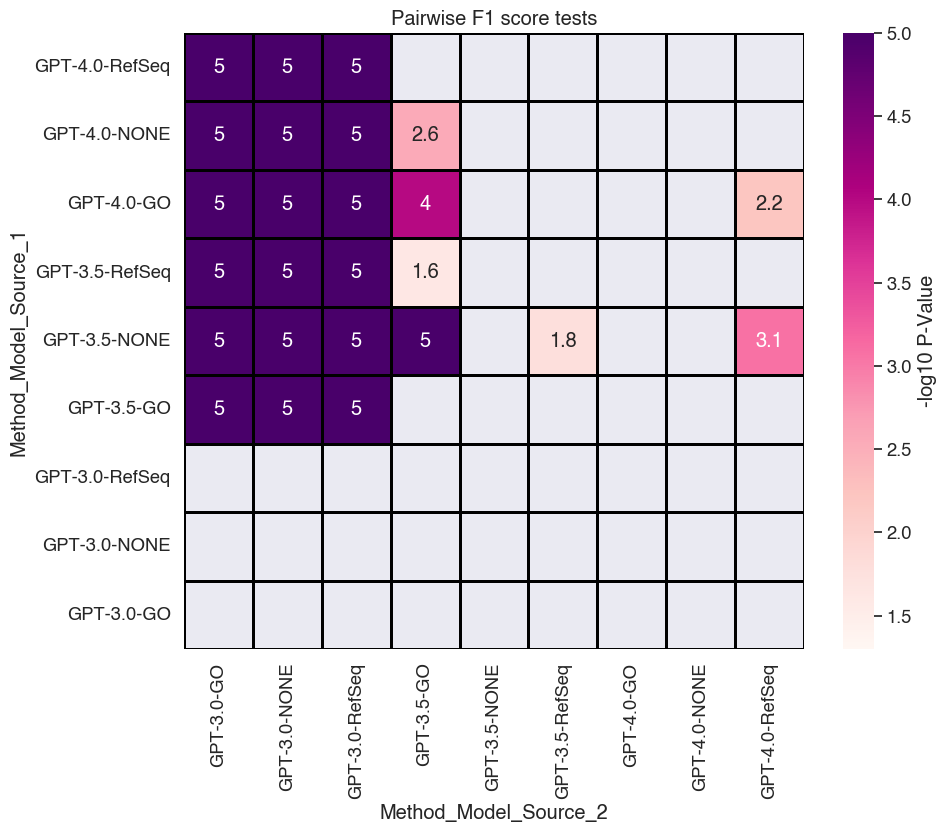

In [362]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
heatmap_data_log = np.log10(heatmap_data)
heatmap_data_log[heatmap_data_log < 0] = -heatmap_data_log[heatmap_data_log < 0]

diag_value = np.nan
shape = heatmap_data_log.shape
#print(shape)
for i in range(min(shape)):
#    print(f'i: {i}')
#    print(f'max(shape)-i: {max(shape)-1-i}')
    heatmap_data_log.iloc[i, max(shape)-1-i] = diag_value

mask = heatmap_data_log > 1.3
    
sns.heatmap(heatmap_data_log, annot=True, cmap='RdPu', cbar_kws={'label': '-log10 P-Value'}, mask=~mask, linewidths=1, linecolor='black', vmin=1.3)
plt.title("Pairwise F1 score tests")
plt.grid(False)
plt.savefig("TALISMAN_ttest.pdf", dpi=300, bbox_inches='tight')

plt.show()

In [120]:
grouped_by_method.columns

Index(['precision', 'recall', 'f1_score'], dtype='object')

In [76]:
df['cutoff']

name
glycolysis-gocam-0-0.005             0.005
glycolysis-gocam-0-0.005             0.005
glycolysis-gocam-0-0.005             0.005
glycolysis-gocam-0-0.005             0.005
glycolysis-gocam-0-0.005             0.005
                                     ...  
HALLMARK_MTORC1_SIGNALING-1-0.005    0.005
HALLMARK_MTORC1_SIGNALING-1-0.005    0.005
HALLMARK_MTORC1_SIGNALING-1-0.005    0.005
HALLMARK_MTORC1_SIGNALING-1-0.005    0.005
HALLMARK_MTORC1_SIGNALING-1-0.005    0.005
Name: cutoff, Length: 26496, dtype: float64

In [75]:
df_orig = df.copy()

#df = df.loc[(df[CUTOFF] == 0.005) & (df["closure"] == True) & (df["top_n"] == 1)] 
df = df.loc[(df['cutoff'] == 0.005)] 
df

,cutoff,closure,top_n,source,model,method,method_desc,run,truncation_factor,prompt_variant,...,unparsed,true_positive_terms,false_positive_terms,unparsed_terms,gene_set_size,precision,recall,recall_general,recall_specific,f1_score
name,,,,,,,,,,,,,,,,,,,,,
glycolysis-gocam-0-0.005,0.005,False,5,NONE,4.0,gpt,no_synopsis-4,gpt-4.no_synopsis.v1,1.0,v1,...,2,GO:0006096,GO:0006006,energy production|atp generation,10,0.500000,0.500000,1.000000,0.200000,0.285714
glycolysis-gocam-0-0.005,0.005,False,10,NONE,4.0,gpt,no_synopsis-4,gpt-4.no_synopsis.v1,1.0,v1,...,2,GO:0006096,GO:0006006,energy production|atp generation,10,0.500000,0.500000,0.200000,0.200000,0.166667
glycolysis-gocam-0-0.005,0.005,False,25,NONE,4.0,gpt,no_synopsis-4,gpt-4.no_synopsis.v1,1.0,v1,...,2,GO:0006096|GO:0006006,NaN,energy production|atp generation,10,1.000000,1.000000,0.250000,0.153846,0.148148
glycolysis-gocam-0-0.005,0.005,False,5000,NONE,4.0,gpt,no_synopsis-4,gpt-4.no_synopsis.v1,1.0,v1,...,2,GO:0006096|GO:0006006,NaN,energy production|atp generation,10,1.000000,1.000000,0.250000,0.142857,0.097561
glycolysis-gocam-0-0.005,0.005,True,5,NONE,4.0,gpt,no_synopsis-4,gpt-4.no_synopsis.v1,1.0,v1,...,2,GO:0006096|GO:0019318|GO:0061621|GO:0006094,NaN,energy production|atp generation,10,1.000000,1.000000,0.666667,0.800000,0.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HALLMARK_MTORC1_SIGNALING-1-0.005,0.005,False,5000,NaN,NaN,NaN,NaN,closure,NaN,NaN,...,0,GO:0044283|GO:0044281|GO:0005737|GO:0019752|GO...,GO:0008525|GO:0009749|GO:0019899|GO:0050709|GO...,NaN,180,0.023480,0.023480,1.000000,1.000000,0.045882
HALLMARK_MTORC1_SIGNALING-1-0.005,0.005,True,5,NaN,NaN,NaN,NaN,closure,NaN,NaN,...,0,GO:0044283|GO:0005737|GO:0019752|GO:0036094|GO...,GO:0008525|GO:0009749|GO:0019899|GO:0050709|GO...,NaN,180,0.000794,0.000794,1.000000,1.000000,0.001587
HALLMARK_MTORC1_SIGNALING-1-0.005,0.005,True,10,NaN,NaN,NaN,NaN,closure,NaN,NaN,...,0,GO:0044283|GO:0005737|GO:0019752|GO:0036094|GO...,GO:0008525|GO:0009749|GO:0019899|GO:0050709|GO...,NaN,180,0.001720,0.001720,1.000000,1.000000,0.003434


## Subset Analysis

In [77]:

go = get_adapter("sqlite:obo:go")
subsets = list(go.subsets())
subsets_by_term = defaultdict(list)
for subset in subsets:
    members = [m for m in go.subset_members(subset) if m.startswith("GO:")]
    for t in members:
        subsets_by_term[t].append(subset)
    members_ancs = go.ancestors(members)
    anc_subset = f"anc_of_{subset}"
    for a in members_ancs:
        if a not in members:
            subsets_by_term[a].append(anc_subset)

In [78]:
go = get_adapter("sqlite:obo:go")
labels = list(go.labels(go.entities()))

In [79]:
lmap = {id: label for id, label in labels}

In [80]:
objs = []
n = 0
for row in df.to_dict(orient="records"):
    n += 1
    if n % 500 == 0:
        print(row['gene_set'])
    for t in row[GO_TERM_IDS]:
        obj = {'model': row.get('model'), 'method': row.get('method') , "term": t, "label": lmap.get(t, t)}
        for s in subsets_by_term.get(t, []):
            obj[s] = 1
        objs.append(obj)
print(len(objs))
subsets_df=pd.DataFrame(objs) 
pd.set_option('display.max_rows', 10)
subsets_df

NameError: name 'GO_TERM_IDS' is not defined

### All subsets

In [19]:
subsets_df.fillna(0).groupby([MODEL, METHOD]).mean(numeric_only=True).style.highlight_max(axis=1, props='font-weight:bold').format(precision=3)

KeyError: 'model'

In [ ]:
def agg_table(this_df, cols, exclude=[None]):
    qcols = [MODEL, METHOD] + cols
    agg_df = this_df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
    for x in exclude:
        agg_df= agg_df.query(f"method != '{x}'")
    return agg_df.reset_index().style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

pd.options.display.precision = 2
pd.set_option("display.precision", 2)

## TABLE: MAIN RESULTS

In [ ]:
CORE_METRICS = [PROPORTION_SIGNIFICANT, HAS_TOP_HIT, NUM_GO_TERMS, NUM_NOVEL, NUM_UNPARSED]
EXCLUDE = ["standard", "standard no ontology", "random", "rank based", "closure"]
agg_table(df, CORE_METRICS, EXCLUDE)
#means.query("method != 'standard'").style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)
#

In [ ]:

qcols = [MODEL, METHOD] + CORE_METRICS

print(METHOD)
#agg_df_orig = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
#agg_df_plot = pd.DataFrame( columns=agg_df_orig.columns)#NULL#pd.DataFrame() 
#print(EXCLUDE)
#agg_df_plot = agg_df_plot.query(f"method in @METHOD")


print(qcols)
agg_df_plot = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
for x in EXCLUDE:
    #print(x)
    agg_df_plot= agg_df_plot.query(f"method != '{x}'")
    
print(agg_df_plot.shape)
print("cols")
print(agg_df_plot.columns)

print("index")
print(agg_df_plot.index)

newindex = agg_df_plot.index
#len = agg_df.index.to_flat_index().size()
#print(len)
#for i in range(1,len):
#    newindex[i] = agg_df.index[i]

#print(agg_df.loc[:, 'model'])

#print(agg_df['num GO terms'])

#rework for significant GO terms
xs = agg_df_plot['num GO terms']/agg_df_plot['num unannotated']
ys = agg_df_plot['num unparsed']/agg_df_plot['num unannotated']
#print(agg_df.index)

print(xs)
yells = ["yellow"]*5
reds = ["red"] *3
purps = ["purple"] *3
orans = ["orange"]*3
#colors = [*yells, *reds, *purps, *orans]
colors = [*reds, *purps, *orans]
print(colors)

plt.figure(figsize=(6,6))
fig, ax = plt.subplots()

ax.scatter(xs,ys,
           c=colors)
#, label=agg_df.index

for i in range(0,len(xs)):
    ax.annotate(agg_df_plot.index[i], (xs[i], ys[i]))
    
ax.set_xlabel("True terms/Error rate")
ax.set_ylabel("Unparsed terms/Error rate")

#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels, loc='upper left')

plt.xlim(0,75)
plt.ylim(0,75)

plt.savefig("true_vs_unparsed_vs_error.pdf", format="pdf", bbox_inches="tight")

plt.show()

### Core subsets

Copy this to [subsets tab](https://docs.google.com/spreadsheets/d/1gGO5IHEg-N0hivtHBO6-rdXtin8hPhw-zv6eYOBgXcE/edit#gid=669935942)

In [ ]:
subsets_cols =  [MODEL, METHOD, "goslim_generic", "anc_of_goslim_generic", "goslim_agr", "anc_of_goslim_agr"]
subsets_grouped = subsets_df.fillna(0).groupby([MODEL, METHOD])[subsets_cols]
means = subsets_grouped.mean(numeric_only=True)
means["closure_of_goslim_generic"] = means["goslim_generic"] + means["anc_of_goslim_generic"]
means["closure_of_goslim_agr"] = means["goslim_agr"] + means["anc_of_goslim_agr"]
means.style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

### TABLE: Above the shoreline in key subsets

[anc subsets tab](https://docs.google.com/spreadsheets/d/1gGO5IHEg-N0hivtHBO6-rdXtin8hPhw-zv6eYOBgXcE/edit#gid=345667144)

In [ ]:
sorted_means = means.sort_values("anc_of_goslim_generic", ascending=False)
filtered = sorted_means[["anc_of_goslim_generic", "anc_of_goslim_agr"]]
filtered.style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

In [ ]:
means[["anc_of_goslim_generic", "anc_of_goslim_agr"]].sort_values("anc_of_goslim_agr", ascending=True).style.highlight_min(axis=0, props='font-weight:bold').format(precision=3)

In [ ]:
# Reset the index of the pivoted DataFrame to have 'profession' as a column
#subsets_df = subsets_df.fillna(0).groupby([MODEL, METHOD])[subsets_cols].mean(numeric_only=True).reset_index()

# Melt the DataFrame to have 'category', 'profession', and 'percentage' columns
#melted_df = subsets_df.melt(id_vars=[MODEL, METHOD], var_name='subset', value_name='proportion')
#melted_df["mm"] = melted_df[MODEL] + melted_df[METHOD]
#melted_df
# Create a bar plot using Seaborn
#plt.figure(figsize=(10, 6))
#sns.barplot(x='subset', y='proportion', hue="mm", data=melted_df)
#plt.title('Subsets by method')
#plt.xlabel('Subset')
#plt.ylabel('Proportion')
#plt.legend(title='Subsets')
#plt.show()

## Evaluation

In [ ]:
agg_table(df, [NUM_GO_TERMS, SIZE_OVERLAP, NR_SIZE_OVERLAP], ["standard"])

In [ ]:
eval_summary_cols = [HAS_TOP_HIT, IN_TOP_5, IN_TOP_10, SIZE_OVERLAP, SIMILARITY, NUM_TERMS, NUM_GO_TERMS, NR_SIZE_OVERLAP, NR_SIMILARITY, MEAN_P_VALUE, MIN_P_VALUE, MAX_P_VALUE, PROPORTION_SIGNIFICANT, NUM_NOVEL]
agg_table(df, eval_summary_cols)

## as above, no perturbation

In [ ]:
df_no_perturb = df.query(f"{GENE_RANDOMIZATION_FACTOR} == 0")
agg_table(df_no_perturb, CORE_METRICS, EXCLUDE)


## Maximums

In [ ]:
df[[MODEL, METHOD] + eval_summary_cols].groupby([MODEL, METHOD]).max(numeric_only=True).style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

### Effect of truncation

Larger gene sets penalize annotation-based GPT methods due to the necessity to truncate to fit in the window size.



In [ ]:

sns.set(color_codes=True)
np.random.seed(sum(map(ord, "regression")))
sns.lmplot(x=GENESET_SIZE, y=TRUNCATION_FACTOR, data=df.query("method=='ontological_synopsis'"))
plt.show()

In [ ]:
dftups = [(method, df.query(f"method=='{method}'")) for method in ["ontological_synopsis", "narrative_synopsis"]]
for m, mdf in dftups:
    mdf.assign(dataset=m)
concatenated = pd.concat([mdf.assign(dataset=m) for m, mdf in dftups])
sns.scatterplot(x=GENESET_SIZE, y=TRUNCATION_FACTOR, data=concatenated, style='dataset', hue='model')

In [ ]:
df.query(f"{GENESET_SIZE} < 50")[[GENESET]].drop_duplicates()

In [ ]:
df_small = df.query(f"{GENESET_SIZE} < 50")
means = df_small[[MODEL, METHOD] + eval_summary_cols].groupby(['model', 'method']).mean(numeric_only=True)
means

In [ ]:
def color_lightness(rgb, lightness_scale):
    h, l, s = colorsys.rgb_to_hls(*rgb)
    return colorsys.hls_to_rgb(h, min(1, l * lightness_scale), s = s)

In [ ]:

agg_df_plot = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
for x in EXCLUDE:
    #print(x)
    agg_df_plot = agg_df_plot.query(f"method != '{x}'")    
    
agg_df_small_plot = df_small.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
for x in EXCLUDE:
    #print(x)
    agg_df_small_plot = agg_df_small_plot.query(f"method != '{x}'")
    
agg_df_plot_std = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).std(numeric_only=True)
for x in EXCLUDE:
    #print(x)
    agg_df_plot_std = agg_df_plot_std.query(f"method != '{x}'")    
    
agg_df_small_plot_std = df_small.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).std(numeric_only=True)
for x in EXCLUDE:
    #print(x)
    agg_df_small_plot_std = agg_df_small_plot_std.query(f"method != '{x}'")


print(agg_df_small_plot.shape)
print("cols")
print(agg_df_small_plot.columns)

print("index")
print(agg_df_small_plot.index)


In [ ]:

qcols = [MODEL, METHOD] + CORE_METRICS

print(METHOD)
#agg_df_orig = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
#agg_df = pd.DataFrame( columns=agg_df_orig.columns)#NULL#pd.DataFrame() 
#print(EXCLUDE)
#agg_df = agg_df_orig.query(f"method in @METHOD")

print(qcols)

newindex = agg_df_plot.index
#len = agg_df.index.to_flat_index().size()
#print(len)
#for i in range(1,len):
#    newindex[i] = agg_df.index[i]

#print(agg_df.loc[:, 'model'])

#print(agg_df['num GO terms'])

#rework for significant GO terms
xs = agg_df_plot['num GO terms']/agg_df_plot['num unannotated']
ys = agg_df_plot['num unparsed']/agg_df_plot['num unannotated']

xs_small = agg_df_small_plot['num GO terms']/agg_df_small_plot['num unannotated']
ys_small = agg_df_small_plot['num unparsed']/agg_df_small_plot['num unannotated']

#print(agg_df.index)

print(xs)
yells = ["yellow"]*5
reds = ["red"] *3
purps = ["purple"] *3
orans = ["orange"]*3

colorr = mpl.colors.ColorConverter.to_rgb("red")
rgbr = [color_lightness(colorr, scale) for scale in [2]]
colorp = mpl.colors.ColorConverter.to_rgb("purple")
rgbp = [color_lightness(colorp, scale) for scale in [2]]
coloro = mpl.colors.ColorConverter.to_rgb("orange")
rgbo = [color_lightness(coloro, scale) for scale in [2]]

redss = rgbr *3
purpss = rgbp *3
oranss = rgbo *3


#colors = [*yells, *reds, *purps, *orans]
colors = [*reds, *purps, *orans]
print(colors)

colors_small = [*redss, *purpss, *oranss]
print(colors_small)

circles= ['o','^','s']*3
#triangles= ['^']*3
#squares= ['s']*3

markers = [*circles]#, *triangles, *squares]

SMALL_SIZE = 6
plt.rc('font', size=SMALL_SIZE)   
plt.figure(figsize=(6,6))
fig, ax = plt.subplots()

#ax.scatter(xs,ys, c=colors, s=50, marker=marker)
#ax.scatter(xs_small,xs_small, c=colors, s=25, marker=marker)

unique_markers = set(markers)
print(unique_markers)
print(markers)

for um in unique_markers:
    #print(um)
    #print(markers.index(um))    
    #print([index for index, elem in enumerate(markers) if elem == um])
    mask = [index for index, elem in enumerate(markers) if elem == um]# markers == um
    maskar = np.array(mask)
    print(mask)
    print(type(mask))
    print(maskar)
    print(type(maskar))
    minv = mask[0]
    maxv = mask[2]
    print(str(minv)+"\t"+str(maxv))
    nowcol = [colors[mask[0]], colors[mask[1]], colors[mask[2]]]
    print(nowcol)
    
    ax.scatter(xs[mask], ys[mask], marker=um, c=nowcol, s=150, alpha=0.5, edgecolors="black",  linewidth=0.5)
    ax.scatter(xs_small[mask], ys_small[mask], marker=um, c=nowcol, s=50, alpha=0.5, edgecolors="black",  linewidth=0.5)
    
#, label=agg_df.index
agg_df_plot_labels = agg_df_plot.index.values
for i in range(0, len(xs)):
    agg_df_plot_labels[i] = (agg_df_plot_labels[i][0] + ": " + agg_df_plot_labels[i][1]).replace("(","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(")","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(" - "," : ")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace("gpt","GPT")        
                
for i in range(0,len(xs)):
    ax.annotate(agg_df_plot_labels[i], (xs[i], ys[i]))
    ax.annotate(agg_df_plot_labels[i], (xs_small[i], ys_small[i]))  
ax.set_xlabel("True terms/Error")
ax.set_ylabel("Unparsed terms/Error")

#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels, loc='upper left')

plt.xlim(5,70)
plt.ylim(5,70)
plt.gca().set_aspect("equal")

plt.savefig("true_vs_unparsed_vs_error.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [ ]:

qcols = [MODEL, METHOD] + CORE_METRICS

print(METHOD)
#agg_df_orig = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
#agg_df = pd.DataFrame( columns=agg_df_orig.columns)#NULL#pd.DataFrame() 
#print(EXCLUDE)
#agg_df = agg_df_orig.query(f"method in @METHOD")

print(qcols)

newindex = agg_df_plot.index
#len = agg_df.index.to_flat_index().size()
#print(len)
#for i in range(1,len):
#    newindex[i] = agg_df.index[i]

#print(agg_df.loc[:, 'model'])

#print(agg_df['num GO terms'])

#rework for significant GO terms
xs = agg_df_plot['has top term']/agg_df_plot['num unannotated']
ys = agg_df_plot['proportion significant']/agg_df_plot['num unannotated']

xs_small = agg_df_small_plot['has top term']/agg_df_small_plot['num unannotated']
ys_small = agg_df_small_plot['proportion significant']/agg_df_small_plot['num unannotated']

#print(agg_df.index)

print(xs)
print(ys)
print(np.max(xs))
print(np.max(ys))
print(np.max(xs_small))
print(np.max(ys_small))


yells = ["yellow"]*5
reds = ["red"] *3
purps = ["purple"] *3
orans = ["orange"]*3

colorr = mpl.colors.ColorConverter.to_rgb("red")
rgbr = [color_lightness(colorr, scale) for scale in [2]]
colorp = mpl.colors.ColorConverter.to_rgb("purple")
rgbp = [color_lightness(colorp, scale) for scale in [2]]
coloro = mpl.colors.ColorConverter.to_rgb("orange")
rgbo = [color_lightness(coloro, scale) for scale in [2]]

redss = rgbr *3
purpss = rgbp *3
oranss = rgbo *3


#colors = [*yells, *reds, *purps, *orans]
colors = [*reds, *purps, *orans]
print(colors)

colors_small = [*redss, *purpss, *oranss]
print(colors_small)

circles= ['o','^','s']*3
#triangles= ['^']*3
#squares= ['s']*3

markers = [*circles]#, *triangles, *squares]

SMALL_SIZE = 6
plt.rc('font', size=SMALL_SIZE)   
plt.figure(figsize=(6,6))
fig, ax = plt.subplots()

#ax.scatter(xs,ys, c=colors, s=50, marker=marker)
#ax.scatter(xs_small,xs_small, c=colors, s=25, marker=marker)

unique_markers = set(markers)
print(unique_markers)
print(markers)

for um in unique_markers:
    #print(um)
    #print(markers.index(um))    
    #print([index for index, elem in enumerate(markers) if elem == um])
    mask = [index for index, elem in enumerate(markers) if elem == um]# markers == um
    maskar = np.array(mask)
    print(mask)
    print(type(mask))
    print(maskar)
    print(type(maskar))
    minv = mask[0]
    maxv = mask[2]
    print(str(minv)+"\t"+str(maxv))
    nowcol = [colors[mask[0]], colors[mask[1]], colors[mask[2]]]
    print(nowcol)
    
    ax.scatter(xs[mask], ys[mask], marker=um, c=nowcol, s=150, alpha=0.5, edgecolors="black",  linewidth=0.5)
    ax.scatter(xs_small[mask], ys_small[mask], marker=um, c=nowcol, s=50, alpha=0.5, edgecolors="black",  linewidth=0.5)
    
#, label=agg_df.index
agg_df_plot_labels = agg_df_plot.index.values
for i in range(0, len(xs)):
    agg_df_plot_labels[i] = (agg_df_plot_labels[i][0] + ": " + agg_df_plot_labels[i][1]).replace("(","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(")","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(" - "," : ")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace("gpt","GPT")        
                
for i in range(0,len(xs)):
    ax.annotate(agg_df_plot_labels[i], (xs[i], ys[i]))
    ax.annotate(agg_df_plot_labels[i], (xs_small[i], ys_small[i]))  
ax.set_xlabel("Has top term/Error")
ax.set_ylabel("Proportion significant/Error")

#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels, loc='upper left')

plt.xlim(0,7)
plt.ylim(0,7)
plt.gca().set_aspect("equal")

plt.savefig("top_vs_proportion_vs_error.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [ ]:

qcols = [MODEL, METHOD] + CORE_METRICS

print(METHOD)
#agg_df_orig = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
#agg_df = pd.DataFrame( columns=agg_df_orig.columns)#NULL#pd.DataFrame() 
#print(EXCLUDE)
#agg_df = agg_df_orig.query(f"method in @METHOD")

print(qcols)

agg_df_plot_all = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD])

#pd.concat(map(lambda x: x[1], groups)).sort_index(
agg_df_plot_all = agg_df_plot_all.apply(lambda x: x)
#
#agg_df_plot_all = agg_df_plot_all.head(1000000)

print(agg_df_plot_all.shape)
type(agg_df_plot_all)
#print(agg_df_plot_all.iloc[:200])
for x in EXCLUDE:
    #print(x)
    agg_df_plot_all = agg_df_plot_all.query(f"method != '{x}'")    
    
agg_df_small_plot_all = df_small.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD])
agg_df_small_plot_all = agg_df_small_plot_all.apply(lambda x: x)

for x in EXCLUDE:
    #print(x)
    agg_df_small_plot_all = agg_df_small_plot_all.query(f"method != '{x}'")
    
newindex = agg_df_plot_all.index
#len = agg_df.index.to_flat_index().size()
#print(len)
#for i in range(1,len):
#    newindex[i] = agg_df.index[i]

#print(agg_df.loc[:, 'model'])
#print(agg_df['num GO terms'])

#rework for significant GO terms
xs = agg_df_plot_all['has top term']
ys = agg_df_plot_all['proportion significant']

xs_small = agg_df_small_plot_all['has top term']
ys_small = agg_df_small_plot_all['proportion significant']

#print(agg_df.index)

#print(xs)
#print(ys)
#print(np.max(xs))
#print(np.max(ys))
#print(np.max(xs_small))
#print(np.max(ys_small))


#yells = ["yellow"]*5
reds = ["red"] *3
purps = ["purple"] *3
orans = ["orange"]*3

colorr = mpl.colors.ColorConverter.to_rgb("red")
rgbr = [color_lightness(colorr, scale) for scale in [2]]
colorp = mpl.colors.ColorConverter.to_rgb("purple")
rgbp = [color_lightness(colorp, scale) for scale in [2]]
coloro = mpl.colors.ColorConverter.to_rgb("orange")
rgbo = [color_lightness(coloro, scale) for scale in [2]]

redss = rgbr *3
purpss = rgbp *3
oranss = rgbo *3


#colors = [*yells, *reds, *purps, *orans]
colors = [*reds, *purps, *orans]
print(colors)

colors_small = [*redss, *purpss, *oranss]
print(colors_small)

circles= ['o','^','s']*3
#triangles= ['^']*3
#squares= ['s']*3

markers = [*circles]#, *triangles, *squares]

SMALL_SIZE = 6
plt.rc('font', size=SMALL_SIZE)   
plt.figure(figsize=(6,6))
fig, ax = plt.subplots()

#ax.scatter(xs,ys, c=colors, s=50, marker=marker)
#ax.scatter(xs_small,xs_small, c=colors, s=25, marker=marker)

unique_markers = set(markers)
print(unique_markers)
print(markers)

for um in unique_markers:
    #print(um)
    #print(markers.index(um))    
    #print([index for index, elem in enumerate(markers) if elem == um])
    mask = [index for index, elem in enumerate(markers) if elem == um]# markers == um
    maskar = np.array(mask)
    #print(mask)
    #print(type(mask))
    #print(maskar)
    #print(type(maskar))
    minv = mask[0]
    maxv = mask[2]
    #print(str(minv)+"\t"+str(maxv))
    nowcol = [colors[mask[0]], colors[mask[1]], colors[mask[2]]]
    #print(nowcol)
    
    ax.scatter(xs[mask], ys[mask], marker=um, c=nowcol, s=150, alpha=0.5, edgecolors="black",  linewidth=0.5)
    ax.scatter(xs_small[mask], ys_small[mask], marker=um, c=nowcol, s=50, alpha=0.5, edgecolors="black",  linewidth=0.5)
    
#, label=agg_df.index
agg_df_plot_labels = agg_df_plot_all.index.values
for i in range(0, len(xs)):
    agg_df_plot_labels[i] = (agg_df_plot_labels[i][0] + ": " + agg_df_plot_labels[i][1]).replace("(","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(")","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(" - "," : ")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace("gpt","GPT")        
                
for i in range(0,len(xs)):
    ax.annotate(agg_df_plot_labels[i], (xs[i], ys[i]))
for i in range(0,len(xs_small)):
    ax.annotate(agg_df_plot_labels[i], (xs_small[i], ys_small[i]))  

ax.set_xlabel("Has top term/Error")
ax.set_ylabel("Proportion significant/Error")

#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels, loc='upper left')

plt.xlim(0,1)
plt.ylim(0,1)
plt.gca().set_aspect("equal")

plt.savefig("top_vs_proportion__individual.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [ ]:
df.columns
#num GO terms = TP
#num unannotated = FP
#num terms
#num unparsed

In [ ]:
CORE_METRICS2 = [FP, TP]
qcols = [MODEL, METHOD] + CORE_METRICS2

print(METHOD)
print(qcols)

agg_df_plot_tpfp = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)

agg_df_plot_tpfp = agg_df_plot_tpfp.apply(lambda x: x)

print(agg_df_plot_tpfp.shape)
type(agg_df_plot_tpfp)
for x in EXCLUDE:
    agg_df_plot_tpfp = agg_df_plot_tpfp.query(f"method != '{x}'")    


agg_df_small_plot_tpfp = df_small.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
agg_df_small_plot_tpfp = agg_df_small_plot_tpfp.apply(lambda x: x)
print(agg_df_small_plot_tpfp.columns)

for x in EXCLUDE:
    agg_df_small_plot_tpfp = agg_df_small_plot_tpfp.query(f"method != '{x}'")
    
newindex = agg_df_plot_tpfp.index

xs = agg_df_plot_tpfp['true positive rate across a set of gene GO annotations']
ys = agg_df_plot_tpfp['false positive rate across a set of gene GO annotations']

xs_small = agg_df_small_plot_tpfp['true positive rate across a set of gene GO annotations']
ys_small = agg_df_small_plot_tpfp['false positive rate across a set of gene GO annotations']

reds = ["red"] *3
purps = ["purple"] *3
orans = ["orange"]*3

colorr = mpl.colors.ColorConverter.to_rgb("red")
rgbr = [color_lightness(colorr, scale) for scale in [2]]
colorp = mpl.colors.ColorConverter.to_rgb("purple")
rgbp = [color_lightness(colorp, scale) for scale in [2]]
coloro = mpl.colors.ColorConverter.to_rgb("orange")
rgbo = [color_lightness(coloro, scale) for scale in [2]]

redss = rgbr *3
purpss = rgbp *3
oranss = rgbo *3

colors = [*reds, *purps, *orans]
print(colors)

colors_small = [*redss, *purpss, *oranss]
print(colors_small)

circles= ['o','^','s']*3

markers = [*circles]

SMALL_SIZE = 6
plt.figure()
plt.rc('font', size=SMALL_SIZE)   
plt.figure(figsize=(10,6))
fig, ax = plt.subplots()

unique_markers = set(markers)
print(unique_markers)
print(markers)

for um in unique_markers:
    mask = [index for index, elem in enumerate(markers) if elem == um]
    maskar = np.array(mask)
    minv = mask[0]
    maxv = mask[2]
    nowcol = [colors[mask[0]], colors[mask[1]], colors[mask[2]]]
    
    ax.scatter(xs[mask], ys[mask], marker=um, c=nowcol, s=150, alpha=0.5, edgecolors="black",  linewidth=0.5)#, marker=um#, c=nowcol
    ax.scatter(xs_small[mask], ys_small[mask], marker=um, c=nowcol, s=50, alpha=0.5, edgecolors="black",  linewidth=0.5)#, marker=um#, c=nowcol
    
agg_df_plot_labels = agg_df_plot_tpfp.index.values
for i in range(0, len(xs)):
    agg_df_plot_labels[i] = (agg_df_plot_labels[i][0] + ": " + agg_df_plot_labels[i][1]).replace("(","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(")","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(" - "," : ")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace("gpt","GPT")        
                
for i in range(0,len(xs)):
    ax.annotate(agg_df_plot_labels[i], (xs[i], ys[i]))
for i in range(0,len(xs_small)):
    ax.annotate(agg_df_plot_labels[i], (xs_small[i], ys_small[i]))  

xmax = 0.3
ymax = 0.6
# Major ticks every 20, minor ticks every 5
xmajor_ticks = np.arange(0, xmax, 0.05)
xminor_ticks = np.arange(0, xmax, 0.01)
ymajor_ticks = np.arange(ymax, 1, 0.1)
yminor_ticks = np.arange(ymax, 1, 0.05)

ax.set_xticks(xmajor_ticks)
ax.set_xticks(xminor_ticks, minor=True)
ax.set_yticks(ymajor_ticks)
ax.set_yticks(yminor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.5)
ax.grid(which='major', alpha=0.5)
#ax.grid(color="blue")


ax.set_xlabel("FP")
ax.set_ylabel("TP")

plt.xlim(0,xmax)
plt.ylim(ymax,1)
#plt.gca().set_aspect("equal")

plt.savefig("TP_vs_FP.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [ ]:
CORE_METRICS3 = [RECALL, PRECISION]
qcols = [MODEL, METHOD] + CORE_METRICS3

print(METHOD)
print(qcols)

agg_df_plot_pr = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
agg_df_plot_pr = agg_df_plot_pr.apply(lambda x: x)

print(agg_df_plot_pr.shape)
type(agg_df_plot_pr)
for x in EXCLUDE:
    agg_df_plot_pr = agg_df_plot_pr.query(f"method != '{x}'")    

print(agg_df_plot_pr.columns)

agg_df_small_plot_pr = df_small.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
agg_df_small_plot_pr = agg_df_small_plot_pr.apply(lambda x: x)

for x in EXCLUDE:
    agg_df_small_plot_pr = agg_df_small_plot_pr.query(f"method != '{x}'")
    
newindex = agg_df_plot_pr.index

xs = agg_df_plot_pr['recall']
ys = agg_df_plot_pr['precision']

xs_small = agg_df_small_plot_pr['recall']
ys_small = agg_df_small_plot_pr['precision']

reds = ["red"] *3
purps = ["purple"] *3
orans = ["orange"]*3

colorr = mpl.colors.ColorConverter.to_rgb("red")
rgbr = [color_lightness(colorr, scale) for scale in [2]]
colorp = mpl.colors.ColorConverter.to_rgb("purple")
rgbp = [color_lightness(colorp, scale) for scale in [2]]
coloro = mpl.colors.ColorConverter.to_rgb("orange")
rgbo = [color_lightness(coloro, scale) for scale in [2]]

redss = rgbr *3
purpss = rgbp *3
oranss = rgbo *3

colors = [*reds, *purps, *orans]
print(colors)

colors_small = [*redss, *purpss, *oranss]
print(colors_small)

circles= ['o','^','s']*3

markers = [*circles]

SMALL_SIZE = 6
plt.figure()
plt.rc('font', size=SMALL_SIZE)   
plt.figure(figsize=(10,6))
fig, ax = plt.subplots()

unique_markers = set(markers)
print(unique_markers)
print(markers)

for um in unique_markers:
    mask = [index for index, elem in enumerate(markers) if elem == um]
    maskar = np.array(mask)
    minv = mask[0]
    maxv = mask[2]
    nowcol = [colors[mask[0]], colors[mask[1]], colors[mask[2]]]
    
    ax.scatter(xs[mask], ys[mask], marker=um, c=nowcol, s=200, alpha=0.5, edgecolors="black",  linewidth=0.5)#, marker=um#, c=nowcol
    ax.scatter(xs_small[mask], ys_small[mask], marker=um, c="white", s=100, alpha=0.5, edgecolors=nowcol,  linewidth=2)#, marker=um#, c=nowcol
    
agg_df_plot_labels = agg_df_plot_pr.index.values
for i in range(0, len(xs)):
    agg_df_plot_labels[i] = (agg_df_plot_labels[i][0] + ": " + agg_df_plot_labels[i][1]).replace("(","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(")","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(" - "," : ")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace("gpt","GPT")        
                
for i in range(0,len(xs)):
    ax.annotate(agg_df_plot_labels[i], (xs[i], ys[i]))
for i in range(0,len(xs_small)):
    ax.annotate(agg_df_plot_labels[i], (xs_small[i], ys_small[i]))  

xmax = 0.3
ymax = 0.6
# Major ticks every 20, minor ticks every 5
xmajor_ticks = np.arange(0, 1, 0.05)
xminor_ticks = np.arange(0, 1, 0.01)
ymajor_ticks = np.arange(0, 1, 0.05)
yminor_ticks = np.arange(0, 1, 0.01)

ax.set_xticks(xmajor_ticks)
ax.set_xticks(xminor_ticks, minor=True)
ax.set_yticks(ymajor_ticks)
ax.set_yticks(yminor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.5)
ax.grid(which='major', alpha=0.5)
#ax.grid(color="blue")


ax.set_xlabel("Recall")
ax.set_ylabel("Precision")

plt.xlim(0,0.1)
plt.ylim(0.8,1)
#plt.gca().set_aspect("equal")

plt.savefig("precision_vs_recall.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [ ]:
agg_df_plot_pr.index

In [ ]:
CORE_METRICS3 = [RECALL, PRECISION]
qcols = [MODEL, METHOD] + CORE_METRICS3

agg_df_plot_pr_all = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD])
agg_df_plot_pr_all = agg_df_plot_pr_all.apply(lambda x: x)

for x in EXCLUDE:
    agg_df_plot_pr_all = agg_df_plot_pr_all.query(f"method != '{x}'")    

agg_df_small_plot_pr_all = df_small.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD])
agg_df_small_plot_pr_all = agg_df_small_plot_pr_all.apply(lambda x: x)

for x in EXCLUDE:
    agg_df_small_plot_pr_all = agg_df_small_plot_pr_all.query(f"method != '{x}'")

print(agg_df_plot_pr_all.columns)


dfpvals = pd.DataFrame(index=range(9),columns=range(9))
print(agg_df_plot_pr_all.loc[:, 'model'].unique())
print(agg_df_plot_pr_all.loc[:, 'method'].unique())
labels = []
labels2 = []
count = 0

for model in agg_df_plot_pr_all.loc[:, 'model'].unique():  
    print("count "+str(count))
    for method in agg_df_plot_pr_all.loc[:, 'method'].unique():
        #print("1 "+model+"\t"+method)
        curmethod = model+"__"+method 
        labels.append(curmethod)
        #print((agg_df_plot_pr_all['model'] == model) & (agg_df_plot_pr_all['method'] == method))
        vals1 = agg_df_plot_pr_all[(agg_df_plot_pr_all['model'] == model) & (agg_df_plot_pr_all['method'] == method)]
        print(vals1.shape)
        count2 = 0
        first = False
        for model2 in agg_df_plot_pr_all.loc[:, 'model'].unique():             
            for method2 in agg_df_plot_pr_all.loc[:, 'method'].unique():
                print("count2 "+str(count2))                
                curmethod2 = model2+"__"+method2 
                if(not first):
                    labels2.append(curmethod2)
                if(curmethod != curmethod2):
                    print("1 "+model+"\t"+method+"\t"+"2 "+model2+"\t"+method2)
                    #print((agg_df_plot_pr_all['model'] == model) & (agg_df_plot_pr_all['method'] == method))
                    vals2 = agg_df_plot_pr_all[(agg_df_plot_pr_all['model'] == model2) & (agg_df_plot_pr_all['method'] == method2)]
                    print(vals2.shape)
                    pval= ttest_ind(vals1['precision'], vals2['precision'], alternative='greater', equal_var = False)
                    print(pval)
                    print(pval[1])
                    #print(type(pval[1]))
                    dfpvals.iloc[count, count2] = pval[1]
                else:
                    dfpvals.iloc[count, count2] = 0
                count2 = count2 + 1
        first = True
        count = count + 1

dfpvals = dfpvals.apply(pd.to_numeric)
dfpvals.index = labels
dfpvals.columns = labels

dfpvals_correct = dfpvals.copy()
dfpvals_correct = multipletests(dfpvals.to_numpy().flatten(), method='fdr_bh')
print(type(dfpvals_correct))
dfpvals_correct = [*dfpvals_correct[1]]
print(type(dfpvals_correct))
print(dfpvals_correct)

dfpvals_correct_lists = [dfpvals_correct[x:x+9] for x in range(0, len(dfpvals_correct), 9)]#list(it.batched(iterable, n))
dfpvals_correct = pd.DataFrame(dfpvals_correct_lists, index =labels, columns =labels)

In [ ]:

#for c in dfpvals.select_dtypes(include = [np.number]).columns:
#    dfpvals[c] = np.log10(dfpvals[c].values)
    
ax = plt.axes()
#dfpvals_plot = dfpvals
#dfpvals_plot[dfpvals_plot < 0.0001] = 1
#dfpvals_plot[dfpvals_plot >= 0.0001] = 0

#dfpvals[dfpvals < 0.0001] = 0

#numeric = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']#
#dfpvalslog = dfpvals.copy()
#for c in [c for c in dfpvals.columns if dfpvals[c].dtype in numeric]:
#    dfpvalslog[c] = np.log10(dfpvals[c])
    
sns.heatmap(dfpvals_correct, cmap="YlGnBu", annot=True, annot_kws={"fontsize":8}, ax = ax)
ax.set_title('Precision t-test')

plt.savefig("methodpairs_precision_correct_ttest.pdf", format="pdf", bbox_inches="tight")


plt.show()

In [ ]:
g = sns.clustermap(dfpvals_correct, cmap="YlGnBu", annot =True,annot_kws={"fontsize":8})

ax = g.ax_heatmap

rorder = g.dendrogram_row.reordered_ind
corder = g.dendrogram_col.reordered_ind

#countr = 0
#for r in dfpvals.index:
#    countc = 0
#    for c in dfpvals.columns:
#        #print(dfpvals.iloc[countr, countc])
#        if(pd.to_numeric(dfpvals.iloc[countr, countc]) < 0.001):
#            outf = "{r:}\t{c:}\t\t\t{nr:}\t{nc:}"
#            print(outf.format(r=countr, c=countc, nr=rorder[countr], nc=corder[countc]))
#            #len(rorder) - rorder[countr]-1
#            ax.add_patch(Rectangle((corder[countc], len(rorder) - rorder[countr]-1), 1, 1, fill=False, edgecolor='orange', lw=2))
#        countc=countc+1
#    countr=countr+1

ax.set_title('Precision t-test')
plt.savefig("methodpairs_precision_ttest_correct_cluster.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [ ]:
CORE_METRICS3 = [RECALL, PRECISION]
qcols = [MODEL, METHOD] + CORE_METRICS3

agg_df_plot_pr_all = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD])
agg_df_plot_pr_all = agg_df_plot_pr_all.apply(lambda x: x)

for x in EXCLUDE:
    agg_df_plot_pr_all = agg_df_plot_pr_all.query(f"method != '{x}'")    

agg_df_small_plot_pr_all = df_small.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD])
agg_df_small_plot_pr_all = agg_df_small_plot_pr_all.apply(lambda x: x)

for x in EXCLUDE:
    agg_df_small_plot_pr_all = agg_df_small_plot_pr_all.query(f"method != '{x}'")

print(agg_df_plot_pr_all.columns)


dfpvals = pd.DataFrame(index=range(9),columns=range(9))
print(agg_df_plot_pr_all.loc[:, 'model'].unique())
print(agg_df_plot_pr_all.loc[:, 'method'].unique())
labels = []
labels2 = []
count = 0

for model in agg_df_plot_pr_all.loc[:, 'model'].unique():  
    print("count "+str(count))
    for method in agg_df_plot_pr_all.loc[:, 'method'].unique():
        #print("1 "+model+"\t"+method)
        curmethod = model+"__"+method 
        labels.append(curmethod)
        #print((agg_df_plot_pr_all['model'] == model) & (agg_df_plot_pr_all['method'] == method))
        vals1 = agg_df_plot_pr_all[(agg_df_plot_pr_all['model'] == model) & (agg_df_plot_pr_all['method'] == method)]
        print(vals1.shape)
        count2 = 0
        first = False
        for model2 in agg_df_plot_pr_all.loc[:, 'model'].unique():             
            for method2 in agg_df_plot_pr_all.loc[:, 'method'].unique():
                print("count2 "+str(count2))                
                curmethod2 = model2+"__"+method2 
                if(not first):
                    labels2.append(curmethod2)
                if(curmethod != curmethod2):
                    print("1 "+model+"\t"+method+"\t"+"2 "+model2+"\t"+method2)
                    #print((agg_df_plot_pr_all['model'] == model) & (agg_df_plot_pr_all['method'] == method))
                    vals2 = agg_df_plot_pr_all[(agg_df_plot_pr_all['model'] == model2) & (agg_df_plot_pr_all['method'] == method2)]
                    print(vals2.shape)
                    pval= ttest_ind(vals1['recall'], vals2['recall'], alternative='greater', equal_var = False)
                    print(pval)
                    print(pval[1])
                    #print(type(pval[1]))
                    dfpvals.iloc[count, count2] = pval[1]
                else:
                    dfpvals.iloc[count, count2] = 0
                count2 = count2 + 1
        first = True
        count = count + 1

dfpvals = dfpvals.apply(pd.to_numeric)
dfpvals.index = labels
dfpvals.columns = labels

dfpvals_correct = dfpvals.copy()
dfpvals_correct = multipletests(dfpvals.to_numpy().flatten(), method='fdr_bh')
print(type(dfpvals_correct))
dfpvals_correct = [*dfpvals_correct[1]]
print(type(dfpvals_correct))
print(dfpvals_correct)

dfpvals_correct_lists = [dfpvals_correct[x:x+9] for x in range(0, len(dfpvals_correct), 9)]#list(it.batched(iterable, n))
dfpvals_correct = pd.DataFrame(dfpvals_correct_lists, index =labels, columns =labels)

dfpvals_correct

In [ ]:

ax = plt.axes()
#dfpvals_plot = dfpvals
#dfpvals_plot[dfpvals_plot < 0.0001] = 1
#dfpvals_plot[dfpvals_plot >= 0.0001] = 0

#dfpvals[dfpvals < 0.0001] = 0

numeric = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
#dfpvalslog = dfpvals.copy()
#for c in [c for c in dfpvals.columns if dfpvals[c].dtype in numeric]:
#    dfpvalslog[c] = np.log10(dfpvals[c])
    
sns.heatmap(dfpvals_correct, cmap="YlGnBu", annot=True, annot_kws={"fontsize":8}, ax = ax)
ax.set_title('Recall t-test')

plt.savefig("methodpairs_recall_ttest_correct.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [ ]:
g = sns.clustermap(dfpvals_correct, cmap="YlGnBu", annot =True, annot_kws={"fontsize":8})

ax = g.ax_heatmap

rorder = g.dendrogram_row.reordered_ind
corder = g.dendrogram_col.reordered_ind

#countr = 0
#for r in dfpvals.index:
#    countc = 0
#    for c in dfpvals.columns:
#        #print(dfpvals.iloc[countr, countc])
#        if(pd.to_numeric(dfpvals.iloc[countr, countc]) < 0.001):
#            outf = "{r:}\t{c:}\t\t\t{nr:}\t{nc:}"
#            #print(outf.format(r=countr, c=countc, nr=rorder[countr], nc=corder[countc]))
#            #len(rorder) - rorder[countr]-1
#            ax.add_patch(Rectangle((corder[countc], len(rorder) - rorder[countr]-1), 1, 1, fill=False, edgecolor='orange', lw=2))
#        countc=countc+1
#    countr=countr+1

ax.set_title('Recall t-test')
plt.savefig("methodpairs_recall_ttest_correct_cluster.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [ ]:

qcols = [MODEL, METHOD] + CORE_METRICS

print(METHOD)
#agg_df_orig = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
#agg_df = pd.DataFrame( columns=agg_df_orig.columns)#NULL#pd.DataFrame() 
#print(EXCLUDE)
#agg_df = agg_df_orig.query(f"method in @METHOD")

print(qcols)

newindex = agg_df_plot.index
#len = agg_df.index.to_flat_index().size()
#print(len)
#for i in range(1,len):
#    newindex[i] = agg_df.index[i]

#print(agg_df.loc[:, 'model'])

#print(agg_df['num GO terms'])

#rework for significant GO terms
xs = agg_df_plot['has top term']
ys = agg_df_plot['proportion significant']
xs_er = agg_df_plot_std['has top term']
ys_er = agg_df_plot_std['proportion significant']

xs_small = agg_df_small_plot['has top term']
ys_small = agg_df_small_plot['proportion significant']
xs_small_er = agg_df_small_plot_std['has top term']
ys_small_er = agg_df_small_plot_std['proportion significant']


#print(agg_df.index)

print(xs)
print(ys)
print(np.max(xs))
print(np.max(ys))
print(np.max(xs_small))
print(np.max(ys_small))


yells = ["yellow"]*5
reds = ["red"] *3
purps = ["purple"] *3
orans = ["orange"]*3

colorr = mpl.colors.ColorConverter.to_rgb("red")
rgbr = [color_lightness(colorr, scale) for scale in [2]]
colorp = mpl.colors.ColorConverter.to_rgb("purple")
rgbp = [color_lightness(colorp, scale) for scale in [2]]
coloro = mpl.colors.ColorConverter.to_rgb("orange")
rgbo = [color_lightness(coloro, scale) for scale in [2]]

redss = rgbr *3
purpss = rgbp *3
oranss = rgbo *3


#colors = [*yells, *reds, *purps, *orans]
colors = [*reds, *purps, *orans]
print(colors)

colors_small = [*redss, *purpss, *oranss]
print(colors_small)

circles= ['o','^','s']*3
#triangles= ['^']*3
#squares= ['s']*3

markers = [*circles]#, *triangles, *squares]

SMALL_SIZE = 6
plt.rc('font', size=SMALL_SIZE)   
plt.figure(figsize=(6,6))
fig, ax = plt.subplots()

#ax.scatter(xs,ys, c=colors, s=50, marker=marker)
#ax.scatter(xs_small,xs_small, c=colors, s=25, marker=marker)

unique_markers = set(markers)
print(unique_markers)
print(markers)

for um in unique_markers:
    #print(um)
    #print(markers.index(um))    
    #print([index for index, elem in enumerate(markers) if elem == um])
    mask = [index for index, elem in enumerate(markers) if elem == um]# markers == um
    maskar = np.array(mask)
    print(mask)
    print(type(mask))
    print(maskar)
    print(type(maskar))
    minv = mask[0]
    maxv = mask[2]
    print(str(minv)+"\t"+str(maxv))
    nowcol = [colors[mask[0]], colors[mask[1]], colors[mask[2]]]
    print(nowcol)
    
    ax.scatter(xs[mask], ys[mask], marker=um, c=nowcol, s=150, alpha=0.5, edgecolors="black",  linewidth=0.5)
    ax.scatter(xs_small[mask], ys_small[mask], marker=um, c=nowcol, s=50, alpha=0.5, edgecolors="black",  linewidth=0.5)

    ax.errorbar(xs[mask], ys[mask], xerr= xs_er[mask], yerr=ys_er[mask], fmt="o", elinewidth=0.4, capsize=0.4)# ecolor=nowcol,
    ax.errorbar(xs_small[mask], ys_small[mask], xerr= xs_small_er[mask], yerr=ys_small_er[mask], fmt="o", elinewidth=0.4, capsize=0.4)
    
#, label=agg_df.index
agg_df_plot_labels = agg_df_plot.index.values
for i in range(0, len(xs)):
    agg_df_plot_labels[i] = (agg_df_plot_labels[i][0] + ": " + agg_df_plot_labels[i][1]).replace("(","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(")","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(" - "," : ")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace("gpt","GPT")        
                
for i in range(0,len(xs)):
    ax.annotate(agg_df_plot_labels[i], (xs[i], ys[i]))
    ax.annotate(agg_df_plot_labels[i], (xs_small[i], ys_small[i]))  
ax.set_xlabel("Has top term")
ax.set_ylabel("Proportion significant")

#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels, loc='upper left')

plt.xlim(-0.2,1)
plt.ylim(-0.2,1)
plt.gca().set_aspect("equal")

plt.savefig("top_vs_proportion_std.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [ ]:
means.query("method != 'standard'").style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

## TABLE: evaluation for gene sets < 75

In [ ]:
agg_table(df_small, CORE_METRICS, EXCLUDE)

## Looking at individual gene sets

In [ ]:

def terms_summary(df, variant="v1", max_rows=9999):
    term_dict = {}
    n = 0
    for _, row in df.iterrows():
        if row[PROMPT_VARIANT] and row[PROMPT_VARIANT] != variant:
            continue
        n += 1
        if n > max_rows:
            break
        model = row['model'] 
        if "turbo" in model:
            model = "turbo"
        elif "davinci" in model:
            model = "dav"
        else:
            model = ""
        method = str(row['method']).replace('_', ' ')
        if method in ["closure", "rank_based", "random"]:
            continue
        mm = f"{model} {method}"
        if method == "standard":
            nr_term_ids = list(filter_redundant(row[TERM_IDS]))
        else:
            nr_term_ids = None
        for ix, t_id in enumerate(row[TERM_IDS]):
            if t_id not in term_dict:
                t = {"id": t_id, "label": go.label(t_id), "redundant": False}
                term_dict[t_id] = t
            else:
                t = term_dict[t_id]
            t[mm] = ix
            if nr_term_ids and t_id not in nr_term_ids:
                t["redundant"] = True
    objs = list(term_dict.values())
    return pd.DataFrame(objs)

In [ ]:
import oaklib.datamodels.obograph as og
from oaklib.utilities.obograph_utils import graph_to_image, default_stylemap_path
!mkdir -p output

MMAP = {"standard": None, 
        "gpt-3.5-turbo.no_synopsis": "NS",
        "gpt-3.5-turbo.ontological_synopsis": "ONT",
        "gpt-3.5-turbo.narrative_synopsis": "NAR",
       }

def viz(geneset, include_std=True, mmap = MMAP, variant="v1"):
    methods = mmap.keys()
    [gsobj] = [c for c in comps if c.name == geneset]
    std = gsobj.payloads["standard"]
    t2p = {e.class_id : e.p_value_adjusted for e in std.enrichment_results}
    terms = set()
    terms.add("GO:0008150")
    terms.add("GO:0003674")
    terms.add("GO:0005575")
    m2t = defaultdict(list)
    t2m = defaultdict(set)
    seeds = []
    for m in methods:
        if m == "standard":
            mv = m
        else:
            mv = f"{m}.{variant}"
        p = gsobj.payloads[mv]
        if include_std or m != "standard":
            terms.update(p.term_ids)
        for t in p.term_ids:
            if t.startswith("MONDO:"):
                continue
            m2t[m].append(t)
            t2m[t].add(m)
            if m == "standard":
                seeds.append(t)
    # rels = go.gap_fill_relationships(list(terms), predicates=[IS_A, PART_OF, "RO:0002211", "RO:0002212", RO:0002213"])
    rels = go.gap_fill_relationships(list(terms), predicates=[IS_A, PART_OF])
    g = go.relationships_to_graph(rels)
    for n in g.nodes:
        if not n.lbl:
            n.lbl = go.label(n.id)
        if not n.lbl:
            n.lbl = n.id
        if n.id in t2p:
            n.lbl += f" {t2p[n.id]:.2e}"
        #for m in t2m[n.id]:
        #    n.lbl += f" [<b>{m}</b>]"
    for m in m2t.keys():
        if m == "standard":
            continue
        for t in m2t[m]:
            n = og.Node(id=f"{mmap[m]}:{t}", lbl=mmap[m])
            g.nodes.append(n)
            g.edges.append(og.Edge(n.id, "has", t))
    outfile = f"output/{geneset.replace(' ', '_')}-{include_std}-{variant}.png"
    graph_to_image(g, seeds=seeds, imgfile=outfile, stylemap="conf/enr-style.json")
    graph_to_image(g, seeds=seeds, imgfile=outfile, stylemap="conf/enr-style.json")
    #return g
    
viz('peroxisome-0')
viz('peroxisome-0', variant="v2")

In [ ]:
def geneset_summary(df, geneset):
    sdf = terms_summary(df.query(f"{GENESET} == '{geneset}'").sort_values("similarity", ascending=False))
    [gsobj] = [c for c in comps if c.name == geneset]
    std = gsobj.payloads["standard"]
    t2p = {e.class_id : e.p_value_adjusted for e in std.enrichment_results}
    sdf["p_label"] = sdf.apply(lambda row: str(row.label) + " " + str(t2p.get(row.id, "")), axis=1)
    return sdf

geneset_summary(df, 'peroxisome-0')

### Peroxisome

In [ ]:
peroxisome = df.query(f"{GENESET} == 'peroxisome-0'").sort_values("similarity", ascending=False)
peroxisome[[MODEL, METHOD] + eval_summary_cols]

In [ ]:
# terms_summary(peroxisome).style.highlight_min(axis=1, props='font-weight:bold', numeric_only=True)
terms_summary(peroxisome)

In [ ]:
terms_summary(peroxisome, "v2")

## Sensory Ataxia

In [ ]:
ataxia = df.query(f"{GENESET} == 'sensory ataxia-0'").sort_values("similarity", ascending=False)
ataxia[[MODEL, METHOD] + eval_summary_cols]                                                  

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)


In [ ]:
ataxia[[MODEL, METHOD, PROMPT_VARIANT, GO_TERM_IDS, NOVEL_LABELS]]

In [ ]:
viz('sensory ataxia-0')

![img](output/sensory_ataxia-0-True-v1.png)

In [ ]:
viz('sensory ataxia-0', variant="v2")

![img](output/sensory_ataxia-0-True-v2.png)

In [ ]:
terms_summary(ataxia)

In [ ]:
def retrieve_payload(geneset, method):
    for comp in comps:
        if comp.name == geneset:
            return comp.payloads[method]

In [ ]:
print(retrieve_payload("sensory ataxia-0", "gpt-3.5-turbo.ontological_synopsis.v1").response_text)

In [ ]:
print(retrieve_payload("sensory ataxia-0", "gpt-3.5-turbo.narrative_synopsis.v1").response_text)

In [ ]:
print(retrieve_payload("sensory ataxia-0", "gpt-3.5-turbo.no_synopsis.v1").response_text)

## T cell proliferation

In [ ]:
tcp = df.query(f"{GENESET} == 'T cell proliferation-0'").sort_values("similarity", ascending=False)
tcp[[MODEL, METHOD] + eval_summary_cols]

In [ ]:
viz('T cell proliferation-0')

![img](output/T_cell_proliferation-0-True-v1.png)

In [ ]:
terms_summary(tcp)

## Endocytosis

In [ ]:
endocytosis = df.query(f"{GENESET} == 'endocytosis-0'").sort_values("similarity", ascending=False)
terms_summary(endocytosis)

In [ ]:
print(retrieve_payload("endocytosis-0", "gpt-3.5-turbo.narrative_synopsis.v1").prompt)

In [ ]:
print(retrieve_payload("endocytosis-0", "gpt-3.5-turbo.narrative_synopsis.v1").response_text)

In [ ]:
print(retrieve_payload("endocytosis-0", "gpt-3.5-turbo.ontological_synopsis.v1").prompt)

## Hydrolysis

In [ ]:
hydrolysis = df.query(f"{GENESET} == 'hydrolase activity, hydrolyzing O-glycosyl compounds-0'").sort_values("similarity", ascending=False)
terms_summary(hydrolysis)

In [ ]:
viz('hydrolase activity, hydrolyzing O-glycosyl compounds-0')

![img](output/hydrolase_activity,_hydrolyzing_O-glycosyl_compounds-0-True-v1.png)

## Variability

In [ ]:
pv_pivot = df.pivot_table(index=[MODEL, METHOD, GENESET], columns=PROMPT_VARIANT, values=PROPORTION_SIGNIFICANT)
# Calculate differences between run "1" and run "2"
pv_pivot['diff'] = pv_pivot["v1"] - pv_pivot["v2"]
pv_pivot

In [ ]:

# Now you can perform statistics on the 'diff' column
df_diff_stats = pv_pivot['diff'].agg(['mean', 'std', 'var', 'min', 'max'])
df_diff_stats['range'] = df_diff_stats['max'] - df_diff_stats['min']
df_diff_stats

In [ ]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

# pivot your dataframe as before
df_pivot = df.pivot_table(index=[MODEL, METHOD, GENESET], columns=PROMPT_VARIANT, values=TERM_IDS, aggfunc=list)
df_pivot

In [ ]:

# calculate Jaccard index for each group
df_pivot['jaccard_index'] = df_pivot.apply(lambda row: jaccard_similarity(row["v1"][0], row["v2"][0]), axis=1)

# reset index to get it back in the form of a DataFrame
result = df_pivot.reset_index()
result

In [ ]:
result['jaccard_index'].describe()

In [ ]:
result.groupby([MODEL])['jaccard_index'].describe()

In [ ]:
result.groupby([MODEL, METHOD])['jaccard_index'].describe()[['count', 'mean', 'std', 'min', 'max']].style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

In [ ]:
summaries = [s for s in list(df[SUMMARY]) if s]
len(summaries)
import random
def random_summary():
    return summaries[int(random.random() * len(summaries))]

random_summary()

In [ ]:
from ontogpt.clients import OpenAIClient

simclient = OpenAIClient(model="text-embedding-ada-002")

def text_similarity(text1, text2):
    return simclient.similarity(text1, text2)

text_similarity("nucleus of cell", "nuclear membrane")

In [ ]:
text_similarity(random_summary(), random_summary())

In [ ]:
rs = random_summary()
text_similarity(rs, rs)

In [ ]:
df_pivot = df.pivot_table(index=[MODEL, METHOD, GENESET], columns=PROMPT_VARIANT, values=SUMMARY, aggfunc=list)
df_pivot

df_pivot['sim'] = df_pivot.apply(lambda row: text_similarity(row["v1"][0], row["v2"][0]), axis=1)
df_pivot['length_diff'] = df_pivot.apply(lambda row: abs(len(row["v1"][0])-len(row["v2"][0])), axis=1)


# reset index to get it back in the form of a DataFrame
result = df_pivot.reset_index()
result

In [ ]:
rnd = result.query("model=='text-davinci-003' and method=='no_synopsis'")
rnd[MODEL]=""
rnd[METHOD]="RANDOM"
rnd["sim"] = rnd.apply(lambda row: text_similarity(random_summary(), random_summary()), axis=1)
rnd

In [ ]:
sim_summary = pd.concat([result, rnd]).groupby([MODEL, METHOD])['sim'].describe()[['count', 'mean', 'std', 'min', 'max']]
sim_summary.style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

In [ ]:
stats_df = result.groupby(METHOD).agg({'sim': [np.mean, np.std]}).reset_index()
stats_df.columns = ['category', 'mean', 'stddev']

# Set the plot style
sns.set(style="whitegrid")

# Create the bar plot with error bars
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='category', y='mean', data=stats_df, yerr=stats_df['stddev'], capsize=.1)

# Add labels and title
plt.xlabel("Category")
plt.ylabel("Mean Score")
plt.title("Mean Score with Standard Deviation for Each Category")

# Show the plot
plt.show()


In [ ]:
diff_summary = result.groupby([MODEL, METHOD])['length_diff'].describe()[['count', 'mean', 'std', 'min', 'max']]
diff_summary.style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

## Unparsed

In [ ]:
def unparsed(df, model):
    novel_term_map = defaultdict(dict)
    for _, row in df.iterrows():
        gs = row[GENESET]
        #if not gs.endswith("-0"):
        #    continue
        gs = gs.replace("-0", "")
        for lbl in row[NOVEL_LABELS]:
            if row[MODEL] != model:
                continue
            m = row[METHOD]
            novel_term_map[lbl]["NAME"] = lbl
            if gs not in novel_term_map[lbl]:
                novel_term_map[lbl][m] = []
            novel_term_map[lbl][m].append(gs)
    novel_df = pd.DataFrame(novel_term_map.values())
    return novel_df

## Potential Hallucinations

Summarize all GO terms that are in all summaries that are not in the closure of annotated terms for any of the genes in the gene set

In [ ]:
def hallucinatons(df, model):
    novel_term_map = defaultdict(dict)
    for _, row in df.iterrows():
        gs = row[GENESET]
        #if not gs.endswith("-0"):
        #    continue
        gs = gs.replace("-0", "")
        for lbl in row[NOVEL_LABELS]:
            if row[MODEL] != model:
                continue
            m = row[METHOD]
            novel_term_map[lbl]["NAME"] = lbl
            if gs not in novel_term_map[lbl]:
                novel_term_map[lbl][m] = []
            novel_term_map[lbl][m].append(gs)
    novel_df = pd.DataFrame(novel_term_map.values())
    return novel_df

In [ ]:
novel_df_turbo = hallucinatons(df, TURBO).reset_index(drop=True)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
novel_df_turbo

In [ ]:
hallucinatons(df, DAVINCI)

In [ ]:
hallucinatons(df, GPT4)

In [ ]:
import tiktoken
enc = tiktoken.encoding_for_model("gpt-4")
enc.encode("negative regulation")

def tok_similarity(t1, t2):
    if t1 is None and t2 is None:
        return 1
    if t1 is None or t2 is None:
        return 0

    toks1 = set(enc.encode(t1))
    toks2 = set(enc.encode(t2))
    return len(toks1.intersection(toks2)) / len(toks1.union(toks2))


In [ ]:
closure_by_gene_set = {}
for comp in comps:
    closure = comp.payloads["closure"].term_strings
    closure_by_gene_set[comp.name] = closure

def hallucinatons_with_best_match(df, model):
    novel_term_map = defaultdict(dict)
    for _, row in df.iterrows():
        gs = row[GENESET]
        # print(gs)
        closure = closure_by_gene_set[gs]
        #if not gs.endswith("-0"):
        #    continue
        gs = gs.replace("-0", "")
        for lbl in row[NOVEL_LABELS]:
            if row[MODEL] != model:
                continue
            m = row[METHOD]
            novel_term_map[lbl]["NAME"] = lbl
            if gs not in novel_term_map[lbl]:
                novel_term_map[lbl][m] = []
            # sims = [(ct, text_similarity(ct, lbl)) for ct in closure]
            sims = [(ct, tok_similarity(ct, lbl)) for ct in closure]
            sims = sorted(sims, key=lambda x: -x[1])
            best = sims[0][0]
            novel_term_map[lbl][m].append((gs, best))
    novel_df = pd.DataFrame(novel_term_map.values())
    return novel_df

novel_df_turbo = hallucinatons_with_best_match(df, TURBO).reset_index(drop=True)
novel_df_turbo

## New Annotations

In [ ]:
endocytosis = df.query(f"{GENESET} == 'endocytosis-0'").sort_values("similarity", ascending=False)
terms_summary(endocytosis)

In [ ]:
viz('endocytosis-0')

![img](output/endocytosis-0-True-v1.png)

### New Annotations

in 2022-03-24, GO `molecular sequesting` only had 6 genes annotated; this increased to 30 in 2023.
If these are past the LLM training date then we would not expect these to influence results. Additionally,


In [ ]:
sequestering = df.query(f"{GENESET} == 'molecular sequestering-0'").sort_values("similarity", ascending=False)
sequestering[eval_summary_cols]                                                           

In [ ]:
terms_summary(sequestering)

In [ ]:
viz('molecular sequestering-0')

![img](output/molecular_sequestering-0-True-v1.png)

## IGRB

This gene set contains genes previously annotated to IGRB, many of which have been since removed

In [ ]:
igrb = df.query(f"{GENESET} == 'ig-receptor-binding-2022-0'").sort_values("similarity", ascending=False)
terms_summary(igrb)

In [ ]:
viz('ig-receptor-binding-2022-0')

![img](output/ig-receptor-binding-2022-0-True-v1.png)

In [ ]:
viz('HALLMARK_GLYCOLYSIS-0')

![img](output/HALLMARK_GLYCOLYSIS-0-True-v1.png)

In [ ]:
viz('HALLMARK_KRAS_SIGNALING_UP-0')

![img](output/HALLMARK_KRAS_SIGNALING_UP-0-True-v1.png)

## Summaries

In [ ]:
objs = []
for c in comps:
    for m, payload in c.payloads.items():
        if payload.summary:
            objs.append({"model": c.model, "geneset": c.name, "method": m, "summary": payload.summary})

In [ ]:
sdf = pd.DataFrame(objs)

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
sdf

In [ ]:
sdf.query("geneset == 'sensory ataxia-0'")